In [5]:
#подключение к гугл_диску
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
from tabulate import tabulate
import matplotlib.pyplot as plt
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

tqdm.pandas()
pd.set_option('display.max_columns', None)

# Предварительный анализ данных.

In [7]:
df = pd.read_csv('/content/drive/MyDrive/ВКР/electronika_regions.csv')

In [8]:
#кол-во строк и столбцов таблицы (357036*38)
df.shape

(357036, 39)

In [9]:
#наименования столбцов таблицы
list(df.columns)

['Order_ID',
 'Email_new',
 'Phone_new',
 'Source',
 'OrderDate',
 'время',
 'месяц',
 'ChangeDate',
 'DeliveryDate',
 'PaymentDate',
 'Status',
 'Status_ID',
 'OneClick',
 'CancelReason',
 'Actions',
 'DeliveryType',
 'PaymentType',
 'Area',
 'Store_ID',
 'FullSum',
 'Discount',
 'IM_Rozn_Sum',
 'Row_ID',
 'Articul',
 'Nom_Name',
 'NomGroup',
 'Quant',
 'RowPrice',
 'RowDiscount',
 'RowSum',
 'Brand',
 'TN',
 'TK',
 'NomFullPath',
 'Week',
 'Nom_ID',
 'Субъект',
 'Город',
 'Region']

Для каждого столбца выведем: количество уникальных значений, нулевых, NaNs и их долю, а также тип данных в столбцах.

In [10]:
def columnValues(df):
    row = [df.nunique(), ((df == 0) | (df == '0')).sum(axis=0), df.isna().sum(), round(df.isna().sum() / len(df) * 100, 1), df.dtypes]
    return row

data = []
for column in df:
    data.append([column] + columnValues(df[column]))

print(tabulate(data, headers=['Column', 'Count Unique', 'Count Zeros', 'Count NaNs','% of NaNs', 'data type'], tablefmt='orgtbl'))

| Column       |   Count Unique |   Count Zeros |   Count NaNs |   % of NaNs | data type   |
|--------------+----------------+---------------+--------------+-------------+-------------|
| Order_ID     |         166794 |             0 |            0 |         0   | object      |
| Email_new    |          99284 |         61516 |            0 |         0   | object      |
| Phone_new    |         123135 |          7575 |            0 |         0   | object      |
| Source       |              4 |             0 |            0 |         0   | object      |
| OrderDate    |             61 |             0 |            0 |         0   | object      |
| время        |          58549 |             0 |            0 |         0   | object      |
| месяц        |              2 |             0 |            0 |         0   | int64       |
| ChangeDate   |         155189 |             0 |            0 |         0   | object      |
| DeliveryDate |            100 |             0 |            0 |      

*Столбцы Email_new и Phone_new содержат схожие данные, идентифицирующие покупателя. Оставляем столбец с номерами телефонов, так как он содержит гораздо меньше нулевых значений (7575), в то время как столбец с электронными адресами - 61 516 нулевых значений. При этом номера телефонов по электронным адресам нельзя никак идентифицировать, т.к. у покупателей с "нулевыми" номерами телефонов e-mail также не указан. Следовательно, столбец Email_new и строки с "нулевыми" номерами телефонов необходимо удалить.*

In [11]:
#удаление столбца Email_new.
df = df.drop(columns=['Email_new'])
df.shape

(357036, 38)

In [12]:
#удаление строк с нулевыми номерами телефонов.
df = df.loc[(df['Phone_new'] != 0) & (df['Phone_new'] != '0')]
df.shape

(349461, 38)

In [13]:
#удаляем чеки, в которых присутствуют отрицательные скидки (возможные ошибки системы)
df = df.loc[~df['Order_ID'].isin(['5429143_BX', '5581960_BX', '5826714_BX'])]
df.shape

(349451, 38)

In [14]:
df[df['TK'].isna()][['Nom_Name', 'NomGroup', 'TK', 'TN']]

,Nom_Name,NomGroup,TK,TN
0,Доставка до точки выдачи,Доставка,NaN,NaN
4,"Доставка ""Стандарт"" зона 0",Доставка,NaN,NaN
6,Доставка до точки выдачи,Доставка,NaN,NaN
10,Доставка до точки выдачи,Доставка,NaN,NaN
11,"Доставка ""Стандарт"" зона 0",Доставка,NaN,NaN
...,...,...,...,...
357025,Доставка до точки выдачи,Доставка,NaN,NaN
357027,Доставка до точки выдачи,Доставка,NaN,NaN
357029,Доставка до точки выдачи,Доставка,NaN,NaN
357031,Доставка до точки выдачи,Доставка,NaN,NaN


In [15]:
#заполнение пустых значений TN и TK
df.loc[(df.Nom_Name == 'Клавиатура Samsung VG-KBD1000'), ['TN', 'TK']] = ['Аксессуары', 'Аксессуары для комп./ноутбуков/принтеров']
df.loc[(df.Nom_Name == 'Музыкальный центр LG CM9740'), ['TN', 'TK']] = ['ТВ-Аудио', 'Аудио-Видео']
df.loc[(df.Nom_Name == 'Колонки LG CMS9740F'), ['TN', 'TK']] = ['Аксессуары', 'Аксессуары для комп./ноутбуков/принтеров']
df.loc[(df.Nom_Name == 'Автокресло Nania Beone SP Plus Boomer Carmin'), ['TN', 'TK']] = ['Детские товары', 'Прогулки и путешествие']
df.loc[(df.Nom_Name == 'Кроватка СКВ-5 544036 п.2 бук'), ['TN', 'TK']] = ['Детские товары', 'Детская комната']
df.loc[(df.Nom_Name == 'Apple iPad Pro ML0H2RU/A Wi-Fi 32Gb gold планшет'), ['TN', 'TK']] = ['Цифровая Техника', 'Планшеты']
df.loc[(df.Nom_Name == 'Apple iPad Pro ML2J2RU/A Wi-Fi Cell 128Gb  silver планшет'), ['TN', 'TK']] = ['Цифровая Техника', 'Планшеты']
df.loc[(df.Nom_Name == 'Автокресло Nania Beone SP Plus Boomer Carmin'), ['TN', 'TK']] = ['Детские товары', 'Прогулки и путешествие']
df.loc[(df.Nom_Name == 'Ресивер+сабвуфер Sony HCD-GT3D'), ['TN', 'TK']] = ['Аксессуары', 'Аксессуары ТВ-Аудио']

In [16]:
# Удалим строки, где в качестве категории товара фигурируют услуги
df = df[df['TN'].notna() & (df['TN'] != 'Услуги')]
df.shape

(186887, 38)

In [17]:
#удаляем строки с нулевыми значениями RowSum, т.к. нам не нужны "бесплатные" товары
df = df[df['RowSum'] != 0]
df.shape

(186471, 38)

In [18]:
#удаляем строки с ошибками, дублированными и тестовыми заказами
df = df.loc[~df['CancelReason'].isin(['Тестовый заказ', 'Несколько заказов', 'Дублирование заказа',
                  'Дублирование заказа техническое', 'Ошибка в модели'])]
df.shape

(181758, 38)

In [19]:
#по столбцу Status также можно исключить дублированные заказы
df = df.loc[~df['Status'].isin(['Дубль заказа'])]
df.shape

(181755, 38)

Для построения рекомендаций нам понадобятся только те пользователи, у которых есть несколько заказов. Будем рассматривать только те случаи, когда их не менее 2.

In [20]:
tmp = df.groupby(['Phone_new', 'Order_ID', 'NomGroup'])['RowSum'].count().reset_index().groupby(['Phone_new', 'Order_ID'])['NomGroup'].count().reset_index()
phones = tmp.groupby('Phone_new')['Order_ID'].count()[tmp.groupby('Phone_new')['Order_ID'].count() > 2].index
df = df[df['Phone_new'].isin(phones)]

# df.to_csv('/content/drive/MyDrive/ВКР/over_2_orders.csv', index=False)

# Сегментация

In [21]:
# рассчитаем сводные показатели
df_clients = pd.DataFrame()
gdf = df.groupby('Phone_new')
df_clients['goods_num'] = gdf['Quant'].sum() # количество купленных товаров
# df_clients['goods_num2'] = gdf['Quant'].count() # количество купленных товаров
df_clients['order_count'] = gdf['Order_ID'].nunique() # количество заказов
df_clients['goods_avg'] = df_clients['goods_num'] / df_clients['order_count'] # среднее количество товаров в чеке
# df_clients['goods_avg2'] = goods_num2 / order_count # среднее количество товаров в чеке
df_clients['avg_check'] = gdf['RowSum'].sum() / df_clients['order_count'] # средний чек
df_clients['paid_share'] = df_clients['order_count'].reset_index().join(df[df['Status'] == 'Выдан клиенту'].groupby('Phone_new')[['Order_ID']].nunique(), on='Phone_new', how='outer', lsuffix='_l').fillna(0).groupby('Phone_new')['Order_ID'].sum() / df_clients['order_count'] # доля выкупленных

In [22]:
df_clients = df_clients.join(
    pd.crosstab(
        df['Phone_new'],
        df['TN'],
        values=df['Quant'],
        aggfunc=lambda x: 1
    ).fillna(0) #.apply(lambda x: x / x.sum(), axis=1)
    , on='Phone_new'
)

df_clients = df_clients.join(
    pd.crosstab(
        df['Phone_new'],
        df['Region'],
        values=df['Quant'],
        aggfunc=lambda x: 1
    ).fillna(0) #.apply(lambda x: x / x.sum(), axis=1)
    , on='Phone_new'
)

df_clients = df_clients.reset_index()
df_clients

,Phone_new,goods_num,order_count,goods_avg,avg_check,paid_share,Автотовары,Аксессуары,Детские товары,"Игры, софт и развлечения",Климат,Крупная бытовая техника,Мебель,Мелкая бытовая техника,Сделай сам,Спорт и активный отдых,ТВ-Аудио,Товары для дома,Цифровая Техника,Приволжский ф.о.,Северо-Западный ф.о.,Сибирский ф.о.,Уральский ф.о.,Центральный ф.о.,Южный ф.о.
0,32565748-000000000,15.0,13,1.153846,14841.692308,0.615385,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1,43553240-575054413251+75,7.0,7,1.000000,6936.714286,0.285714,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,55485656-57565656575275,205.0,181,1.132597,12411.254144,0.613260,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
3,55555555-51535356545777,3.0,3,1.000000,75659.666667,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,55555750-48525355535175,8.0,8,1.000000,5804.875000,0.750000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4695,55575757-56525150544979,12.0,8,1.500000,5533.000000,0.500000,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4696,55575757-57545154575173,22.0,7,3.142857,16672.000000,0.142857,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4697,55575757-57545754495174,3.0,3,1.000000,3222.000000,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4698,55575757-57565548505473,7.0,7,1.000000,7128.571429,0.571429,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


## Корреляция

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.context('seaborn');

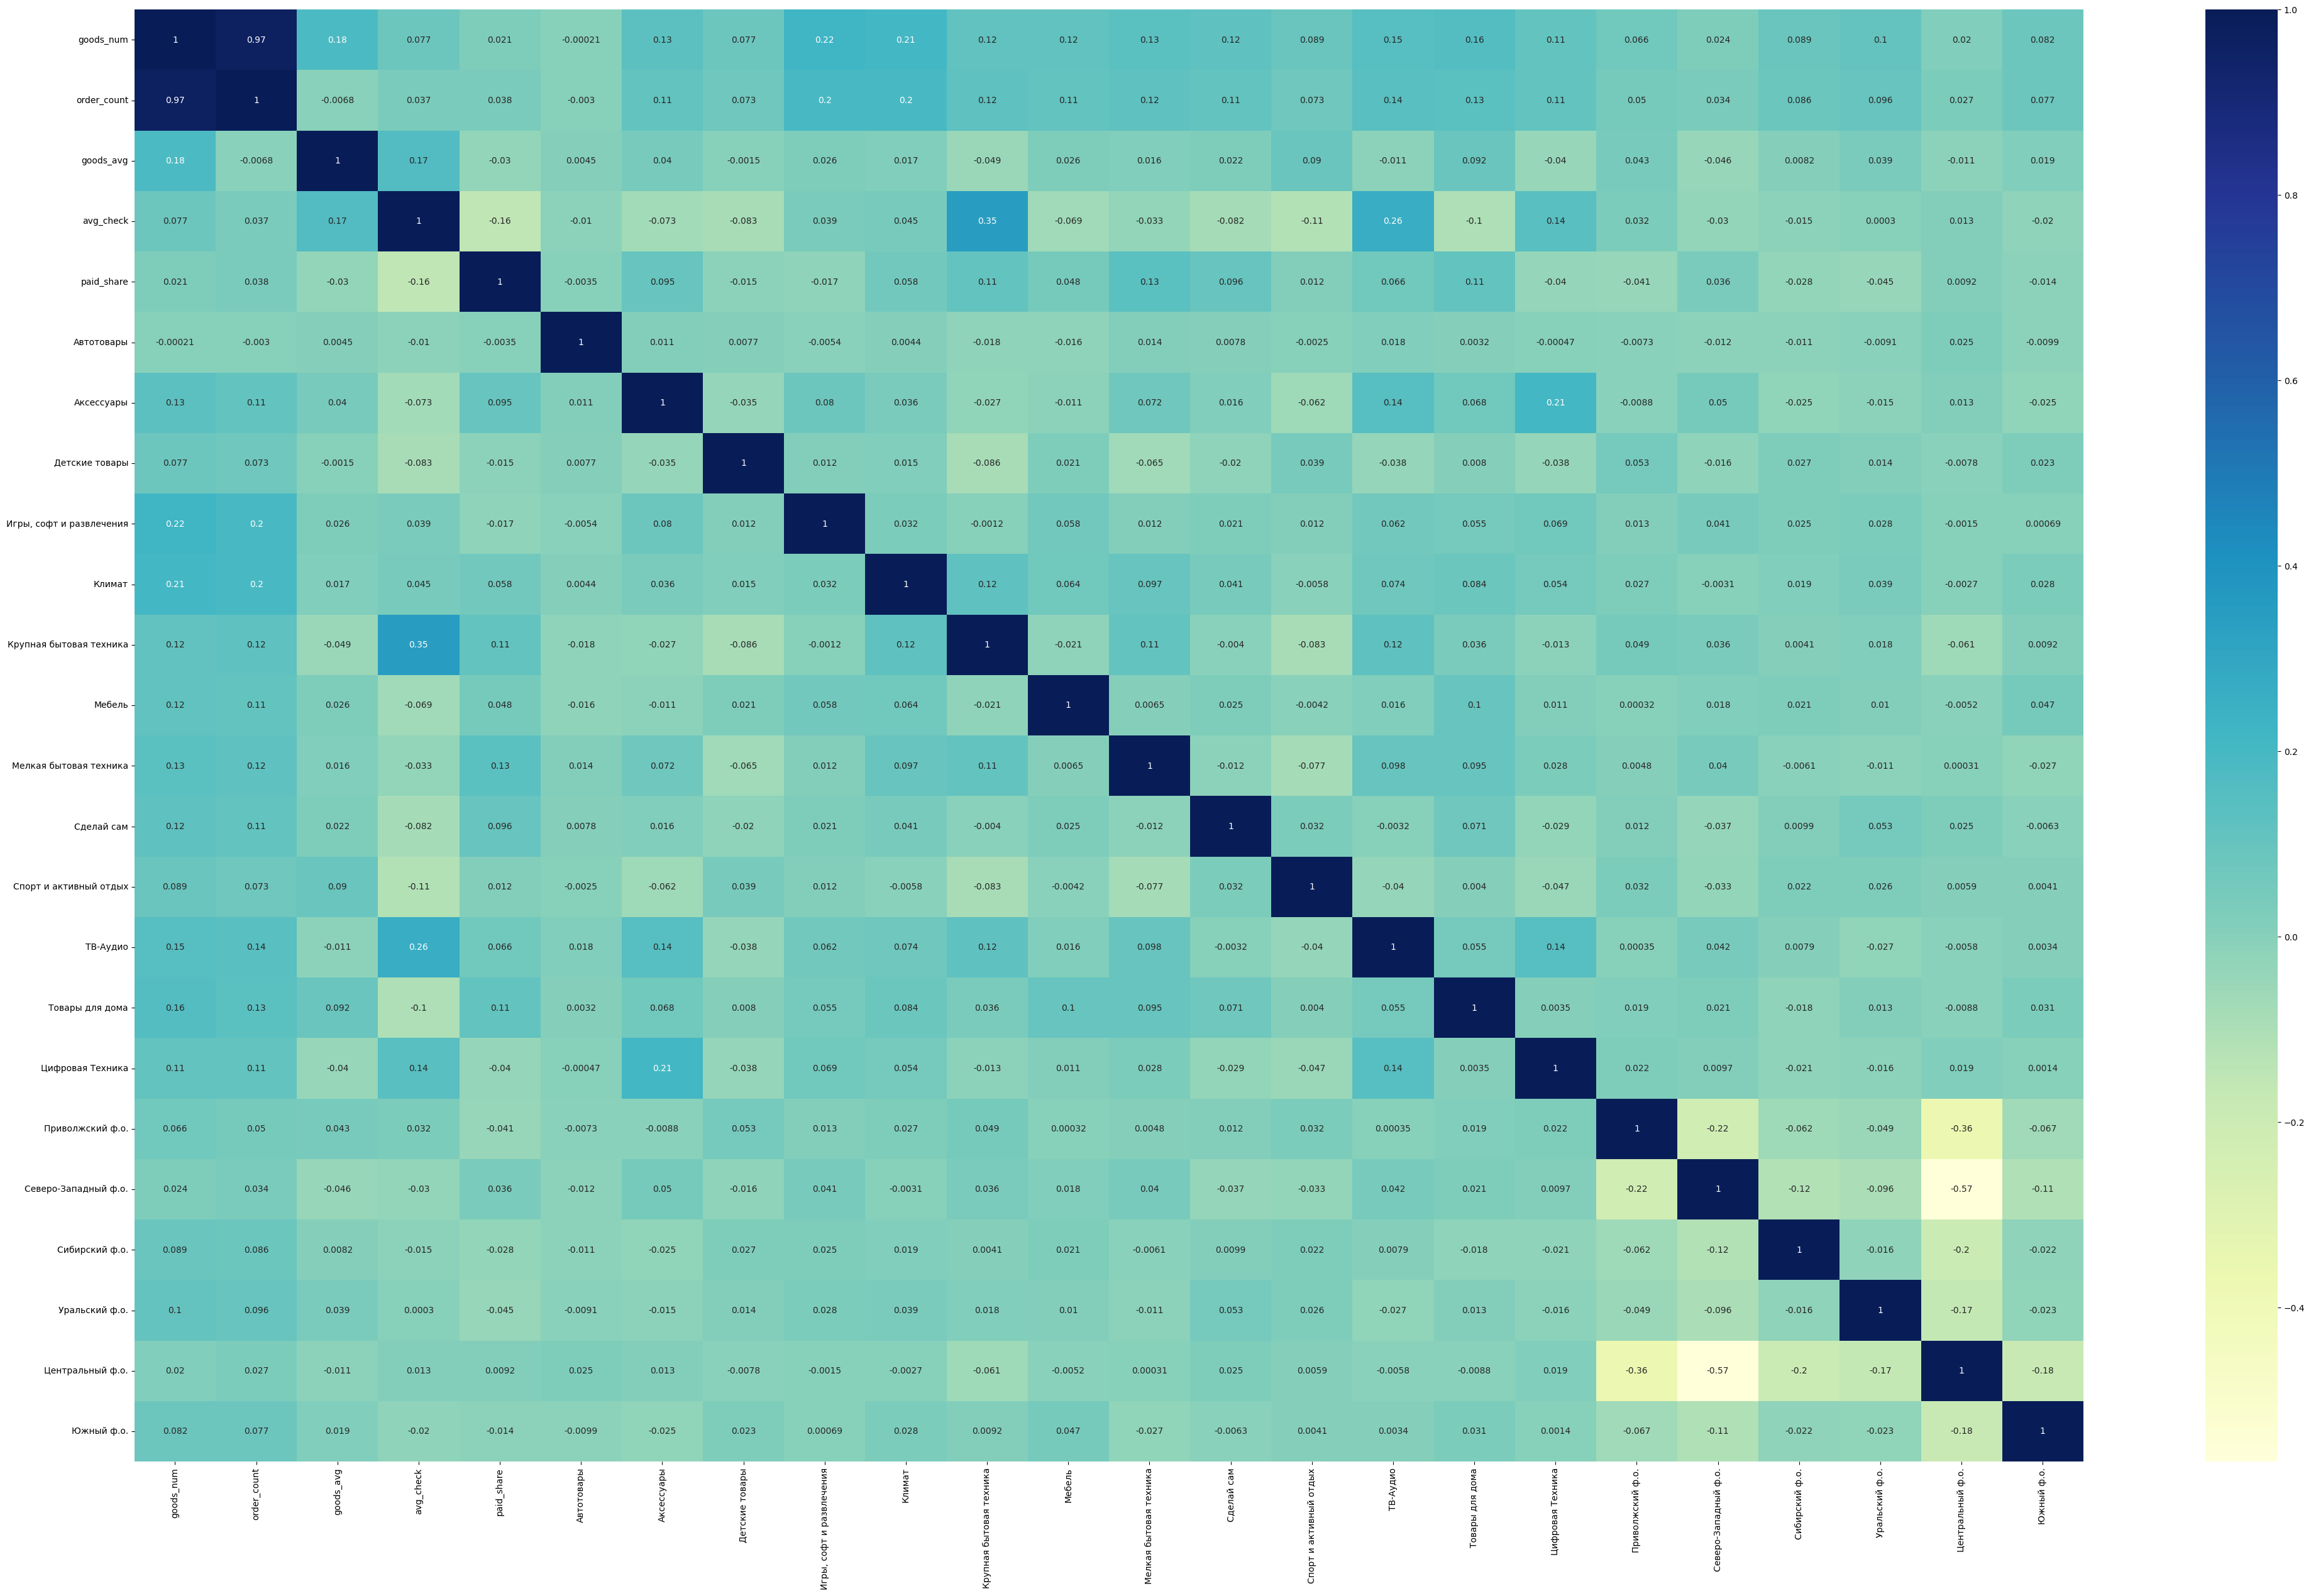

In [24]:
fig = plt.figure(figsize = (50, 30))
sns.heatmap(df_clients.corr(), annot=True, cmap='YlGnBu');

In [25]:
corr = df_clients.corr(method='spearman')
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,goods_num,order_count,goods_avg,avg_check,paid_share,Автотовары,Аксессуары,Детские товары,"Игры, софт и развлечения",Климат,Крупная бытовая техника,Мебель,Мелкая бытовая техника,Сделай сам,Спорт и активный отдых,ТВ-Аудио,Товары для дома,Цифровая Техника,Приволжский ф.о.,Северо-Западный ф.о.,Сибирский ф.о.,Уральский ф.о.,Центральный ф.о.,Южный ф.о.
goods_num,1.00,0.78,0.71,0.19,0.07,0.00,0.20,0.05,0.08,0.18,0.19,0.12,0.22,0.17,0.17,0.21,0.26,0.16,0.02,-0.03,0.01,0.00,0.03,0.02
order_count,0.78,1.00,0.19,0.18,0.03,-0.01,0.18,0.06,0.08,0.19,0.25,0.10,0.27,0.15,0.11,0.26,0.20,0.23,0.02,-0.01,0.01,0.00,0.02,0.01
goods_avg,0.71,0.19,1.00,0.09,0.05,0.02,0.13,0.03,0.05,0.08,0.01,0.09,0.05,0.10,0.15,0.03,0.19,0.01,0.02,-0.04,0.00,0.00,0.02,0.02
avg_check,0.19,0.18,0.09,1.00,-0.13,-0.01,-0.07,-0.07,0.04,0.09,0.49,-0.06,0.03,-0.05,-0.14,0.32,-0.12,0.22,0.04,-0.02,-0.01,0.01,-0.00,-0.01
paid_share,0.07,0.03,0.05,-0.13,1.00,-0.01,0.10,-0.02,-0.02,0.06,0.11,0.05,0.14,0.10,0.01,0.07,0.12,-0.03,-0.04,0.03,-0.03,-0.05,0.01,-0.01
Автотовары,0.00,-0.01,0.02,-0.01,-0.01,1.00,0.01,0.01,-0.01,0.00,-0.02,-0.02,0.01,0.01,-0.00,0.02,0.00,-0.00,-0.01,-0.01,-0.01,-0.01,0.02,-0.01
Аксессуары,0.20,0.18,0.13,-0.07,0.10,0.01,1.00,-0.04,0.08,0.04,-0.03,-0.01,0.07,0.02,-0.06,0.14,0.07,0.21,-0.01,0.05,-0.02,-0.01,0.01,-0.03
Детские товары,0.05,0.06,0.03,-0.07,-0.02,0.01,-0.04,1.00,0.01,0.02,-0.09,0.02,-0.06,-0.02,0.04,-0.04,0.01,-0.04,0.05,-0.02,0.03,0.01,-0.01,0.02
"Игры, софт и развлечения",0.08,0.08,0.05,0.04,-0.02,-0.01,0.08,0.01,1.00,0.03,-0.00,0.06,0.01,0.02,0.01,0.06,0.05,0.07,0.01,0.04,0.03,0.03,-0.00,0.00
Климат,0.18,0.19,0.08,0.09,0.06,0.00,0.04,0.02,0.03,1.00,0.12,0.06,0.10,0.04,-0.01,0.07,0.08,0.05,0.03,-0.00,0.02,0.04,-0.00,0.03


## Удаление выбросов

In [26]:
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor

In [27]:
import pandas as pd
import numpy as np

In [28]:
%%time
outliers = IsolationForest(n_estimators=20, random_state=0).fit_predict(df_clients.drop(columns=['Phone_new']).values)  # fit 3 trees  
outliers = (outliers+1)//2

print('% of outliers with Isolation forest:', 1 - (np.sum(outliers) / df_clients.drop(columns=['Phone_new']).shape[0]))

% of outliers with Isolation forest: 0.19148936170212771
CPU times: user 83.8 ms, sys: 272 µs, total: 84 ms
Wall time: 95.9 ms


In [29]:
df_clients = df_clients.loc[np.array(df_clients.index)[outliers == 1]]

In [30]:
df_clients.shape

(3800, 25)

## Нормализация

In [31]:
from sklearn import preprocessing

In [32]:
scaler = preprocessing.StandardScaler()
# normalize
X = scaler.fit_transform(df_clients.drop(columns=['Phone_new']))

## Кластеризация K-means

In [33]:
from sklearn.cluster import KMeans #DBSCAN, AgglomerativeClustering, MeanShift, MiniBatchKMeans, OPTICS
from scipy.spatial.distance import cdist

from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score

### Метод локтя

In [34]:
%%time
# k means determine k
distortions = []
labels = []
# inertia = []
K = range(1, 16)
for k in tqdm(K):
    kmeanModel = KMeans(n_clusters=k, max_iter=500, random_state=72, n_init=20).fit(X)
    labels.append(kmeanModel.predict(X))
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    # inertia.append(np.sqrt(kmeanModel.inertia_))
    
    print('{} / {}'.format(k, K[-1]))

  7%|▋         | 1/15 [00:00<00:06,  2.15it/s]

1 / 15


 13%|█▎        | 2/15 [00:02<00:16,  1.28s/it]

2 / 15


 20%|██        | 3/15 [00:03<00:16,  1.37s/it]

3 / 15


 27%|██▋       | 4/15 [00:05<00:17,  1.59s/it]

4 / 15


 33%|███▎      | 5/15 [00:07<00:15,  1.57s/it]

5 / 15


 40%|████      | 6/15 [00:08<00:13,  1.49s/it]

6 / 15


 47%|████▋     | 7/15 [00:10<00:12,  1.54s/it]

7 / 15


 53%|█████▎    | 8/15 [00:12<00:11,  1.62s/it]

8 / 15


 60%|██████    | 9/15 [00:15<00:14,  2.34s/it]

9 / 15


 67%|██████▋   | 10/15 [00:17<00:10,  2.19s/it]

10 / 15


 73%|███████▎  | 11/15 [00:19<00:08,  2.06s/it]

11 / 15


 80%|████████  | 12/15 [00:21<00:06,  2.05s/it]

12 / 15


 87%|████████▋ | 13/15 [00:23<00:04,  2.10s/it]

13 / 15


 93%|█████████▎| 14/15 [00:28<00:02,  2.73s/it]

14 / 15


100%|██████████| 15/15 [00:30<00:00,  2.03s/it]

15 / 15
CPU times: user 33.9 s, sys: 17 s, total: 50.8 s
Wall time: 30.4 s


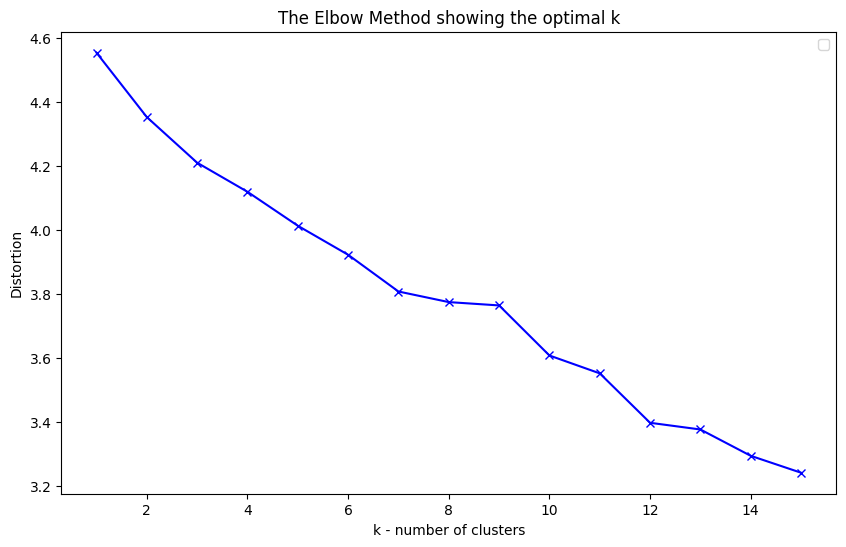

In [35]:
#определение оптимального к-ва кластеров методом локтя
plt.figure(figsize=(10, 6))
# plt.axvline(9, 0, 1, label='slope change #1', color='red')
# plt.axvline(13, 0, 1, label='slope change #2', color='orange')
plt.plot(K, distortions, 'bx-')
plt.xlabel('k - number of clusters')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.legend(); plt.show()

самые оптимальные: 7, 10 и 12 кластеров

### Дэвис-Боулдин

In [36]:
results_db_kmeans = {}
for i in tqdm(range(2, 16)):
    db_index = davies_bouldin_score(X, labels[i - 1])
    results_db_kmeans.update({i: db_index})

100%|██████████| 14/14 [00:00<00:00, 162.73it/s]


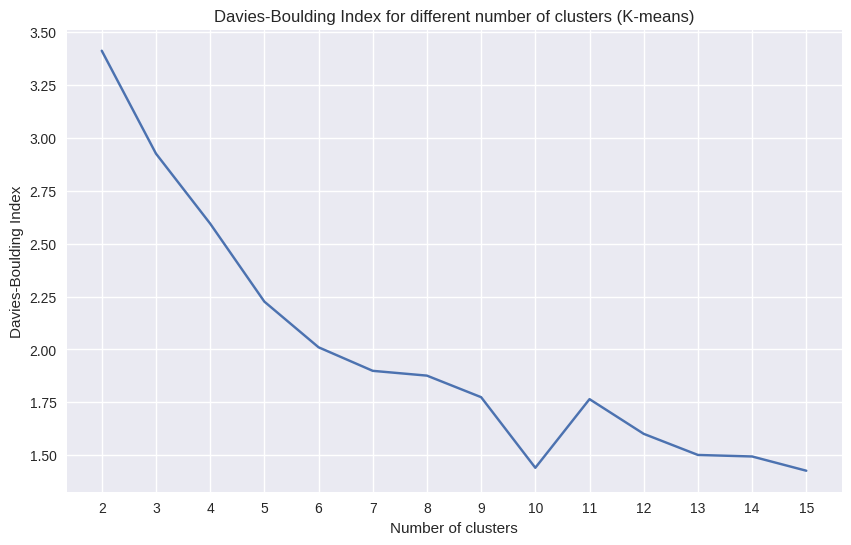

In [37]:
plt.style.use('seaborn')
plt.figure(figsize=(10, 6))

plt.plot(list(results_db_kmeans.keys()), list(results_db_kmeans.values()))

plt.xticks(np.arange(2, 16, step = 1))
plt.xlabel('Number of clusters')
plt.ylabel('Davies-Boulding Index')
plt.title('Davies-Boulding Index for different number of clusters (K-means)')
plt.show()

Самый оптимальный: 10

### Силуэт

In [38]:
results_sil_kmeans = {}
for i in tqdm(range(2, 16)):
    sil_score = silhouette_score(X, labels[i - 1])
    results_sil_kmeans.update({i: sil_score})

100%|██████████| 14/14 [00:05<00:00,  2.74it/s]


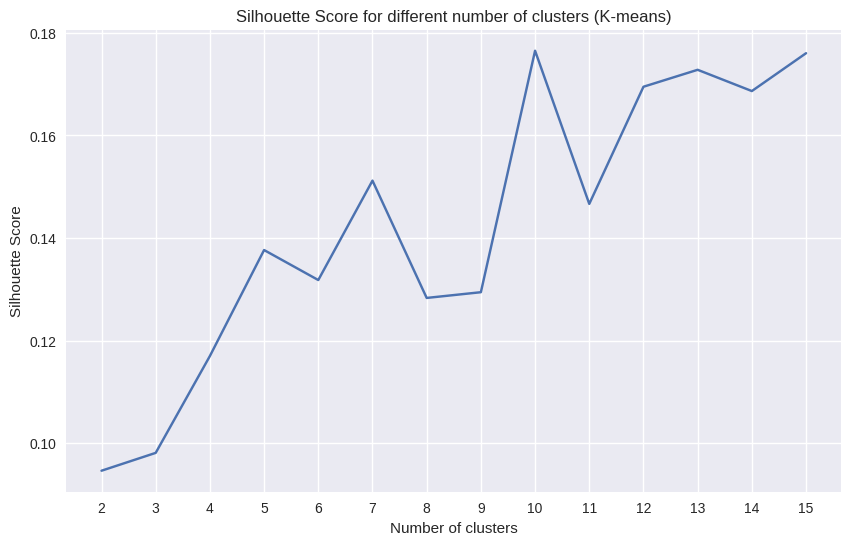

In [39]:
plt.figure(figsize=(10, 6))

plt.plot(list(results_sil_kmeans.keys()), list(results_sil_kmeans.values()), label = 'Silhouette Score')

plt.xticks(np.arange(2, 16, step = 1))
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for different number of clusters (K-means)')
plt.show()

Самый оптимальный: 10

### Калински-Харабаш

In [40]:
results_ch_kmeans = {}
for i in tqdm(range(2, 16)):
    ch_score = calinski_harabasz_score(X, labels[i - 1])
    results_ch_kmeans.update({i: ch_score})

100%|██████████| 14/14 [00:00<00:00, 286.41it/s]


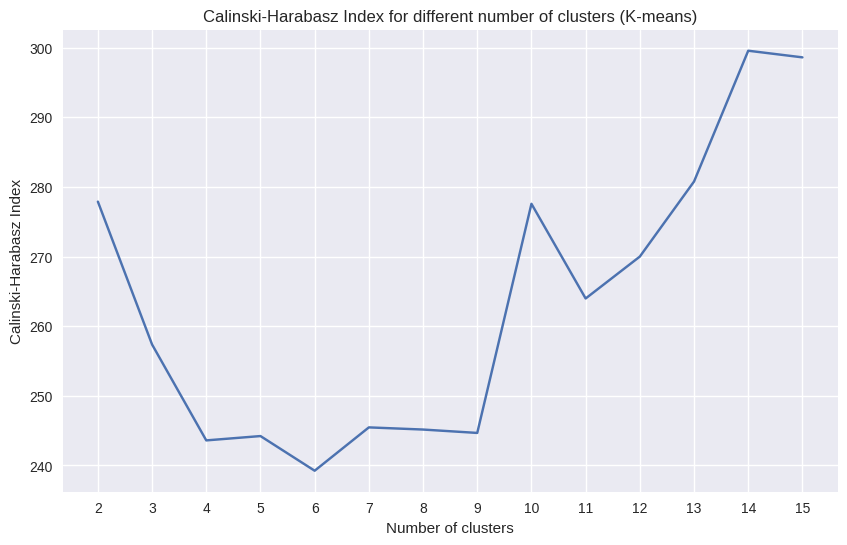

In [41]:
plt.figure(figsize=(10, 6))

plt.plot(list(results_ch_kmeans.keys()), list(results_ch_kmeans.values()), label = 'Calinski-Harabasz Index')

plt.xticks(np.arange(2, 16, step = 1))
plt.xlabel('Number of clusters')
plt.ylabel('Calinski-Harabasz Index')
plt.title('Calinski-Harabasz Index for different number of clusters (K-means)')
plt.show()

Самый оптимальный: 10

**Вывод:** По итогам применения 4 методов выяснилось что наилучшее количество сегментов - 10 штук.

In [42]:
df_clients['label'] = labels[10 - 1]
# df = df.drop(columns=['label'])
df = df.join(df_clients.groupby('Phone_new')['label'].min(), on='Phone_new', how='inner')

# df.to_csv('/content/drive/MyDrive/ВКР/over_2_orders_clusters.csv', index=False)

### Кластеры

Посмотрим на долю каждого кластера.

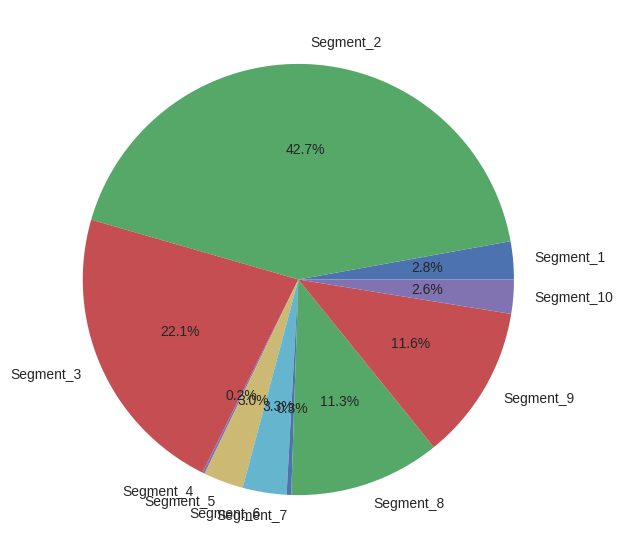

In [43]:
fig = plt.figure(figsize=(10, 7))
data = list(df_clients.groupby('label')['Phone_new'].count())
plt.pie(data, labels=[('Segment_' + str(i)) for i in range(1, 11)], autopct='%1.1f%%')

plt.show()

In [44]:
cluster_df = df_clients.groupby('label').mean()
cluster_df

,goods_num,order_count,goods_avg,avg_check,paid_share,Автотовары,Аксессуары,Детские товары,"Игры, софт и развлечения",Климат,Крупная бытовая техника,Мебель,Мелкая бытовая техника,Сделай сам,Спорт и активный отдых,ТВ-Аудио,Товары для дома,Цифровая Техника,Приволжский ф.о.,Северо-Западный ф.о.,Сибирский ф.о.,Уральский ф.о.,Центральный ф.о.,Южный ф.о.
label,,,,,,,,,,,,,,,,,,,,,,,,
0,4.685185,3.759259,1.280864,11506.548611,0.586806,0.0,0.074074,0.074074,0.0,1.000000,0.333333,0.064815,0.231481,0.092593,0.037037,0.092593,0.055556,0.166667,0.129630,0.333333,0.0,0.0,0.555556,0.0
1,5.035142,3.859433,1.301323,10471.303063,0.504139,0.0,0.188039,0.109125,0.0,0.000000,0.265721,0.070284,0.337855,0.173859,0.191739,0.000000,0.094328,0.221332,0.000000,0.001850,0.0,0.0,1.000000,0.0
2,4.516052,3.651605,1.230115,10149.488604,0.509262,0.0,0.218787,0.107015,0.0,0.000000,0.313912,0.067776,0.353151,0.155767,0.156956,0.000000,0.080856,0.204518,0.000000,1.000000,0.0,0.0,0.030916,0.0
3,3.714286,3.428571,1.064286,9194.623810,0.502381,1.0,0.000000,0.142857,0.0,0.142857,0.000000,0.000000,0.428571,0.142857,0.000000,0.285714,0.000000,0.285714,0.142857,0.000000,0.0,0.0,0.857143,0.0
4,4.464912,3.412281,1.307018,10140.420419,0.446979,0.0,0.043860,0.140351,0.0,0.035088,0.254386,0.114035,0.201754,0.096491,0.166667,0.078947,0.043860,0.122807,0.000000,0.000000,0.0,0.0,0.043860,1.0
5,3.904000,3.512000,1.115067,9673.104476,0.453267,0.0,0.072000,0.024000,0.0,0.008000,0.320000,0.064000,0.320000,0.192000,0.152000,0.096000,0.032000,0.136000,0.000000,0.000000,1.0,0.0,0.024000,0.0
6,4.076923,3.692308,1.064103,11388.944872,0.333333,0.0,0.153846,0.000000,1.0,0.000000,0.076923,0.076923,0.153846,0.076923,0.076923,0.230769,0.000000,0.076923,0.000000,0.384615,0.0,0.0,0.692308,0.0
7,4.440835,3.556845,1.236195,10941.909333,0.471685,0.0,0.139211,0.132251,0.0,0.000000,0.306265,0.051044,0.280742,0.169374,0.169374,0.078886,0.076566,0.174014,1.000000,0.000000,0.0,0.0,0.023202,0.0
8,4.979638,4.323529,1.169220,18906.342535,0.542725,0.0,0.271493,0.020362,0.0,0.000000,0.269231,0.040724,0.303167,0.092760,0.033937,0.995475,0.047511,0.233032,0.009050,0.355204,0.0,0.0,0.649321,0.0


Посмотрим на распределение величин по кластерам

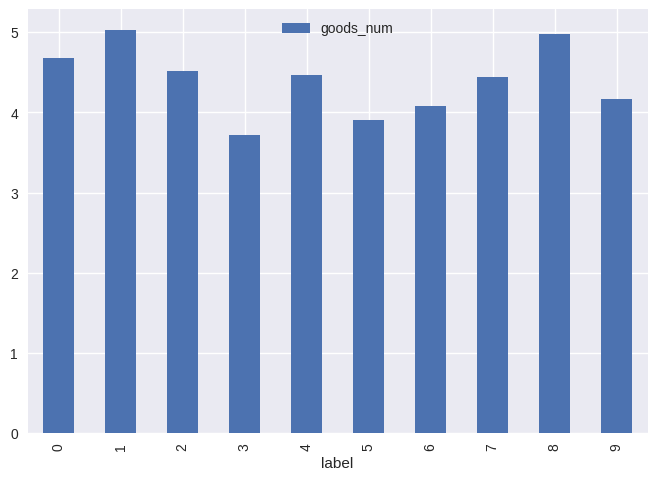

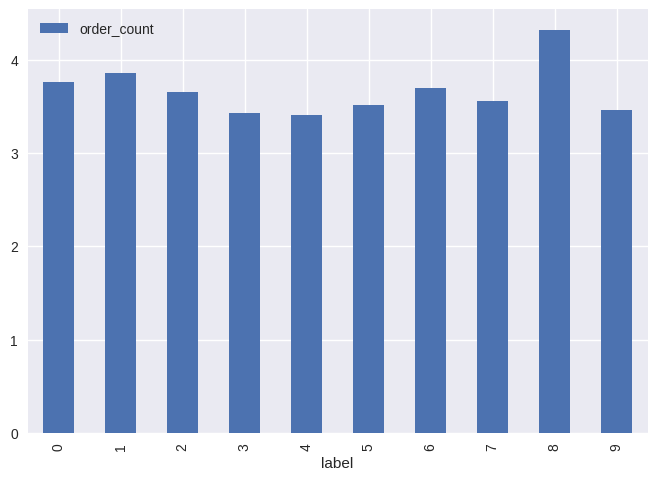

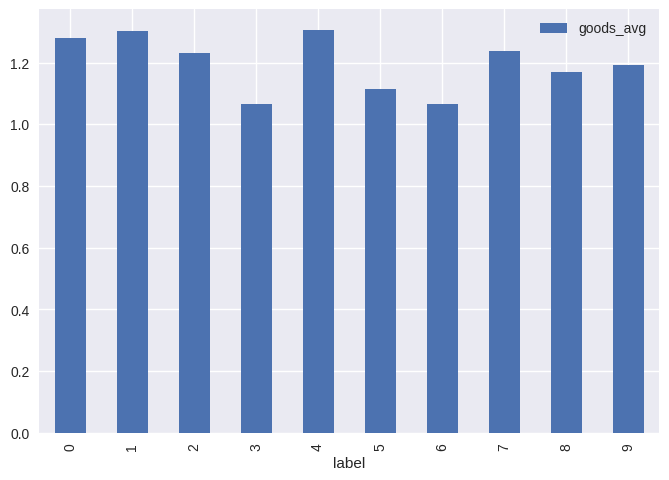

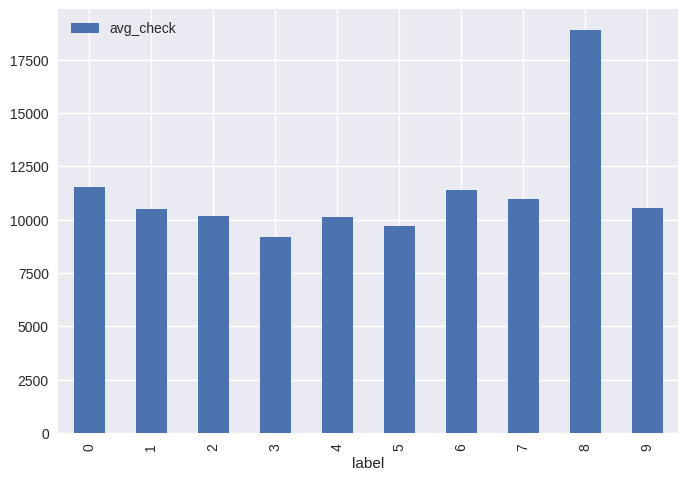

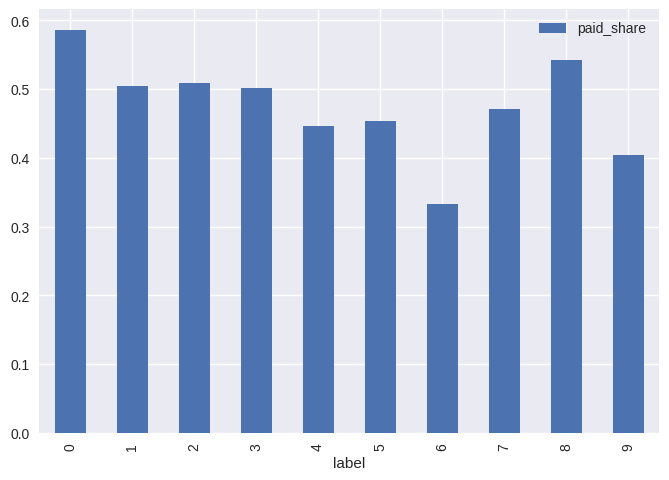

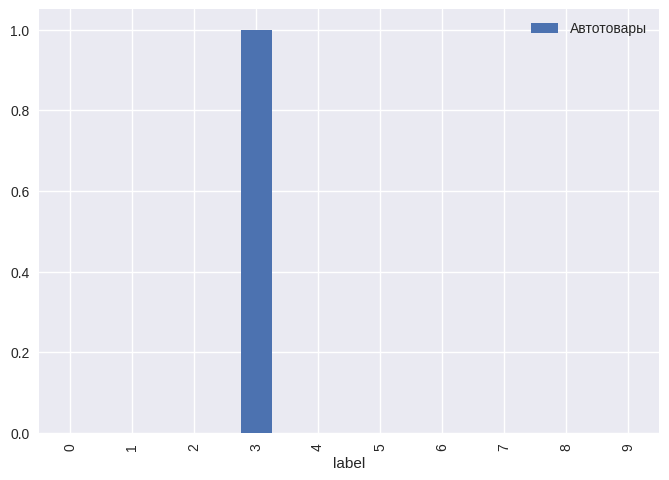

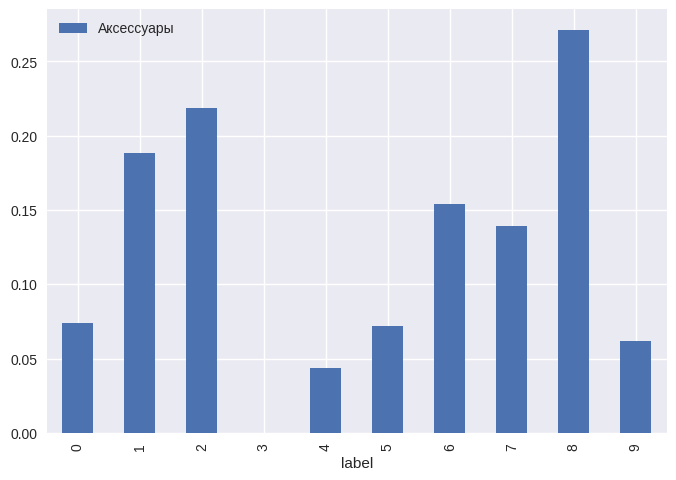

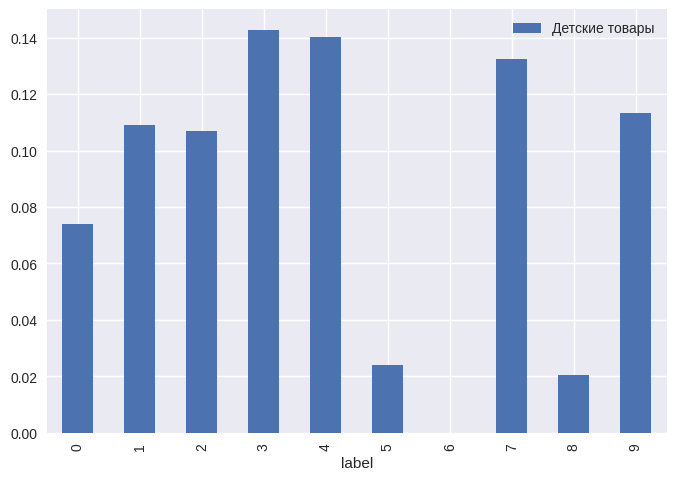

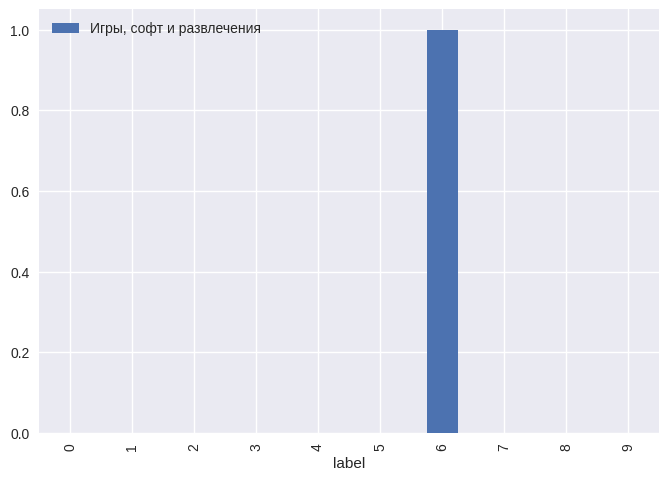

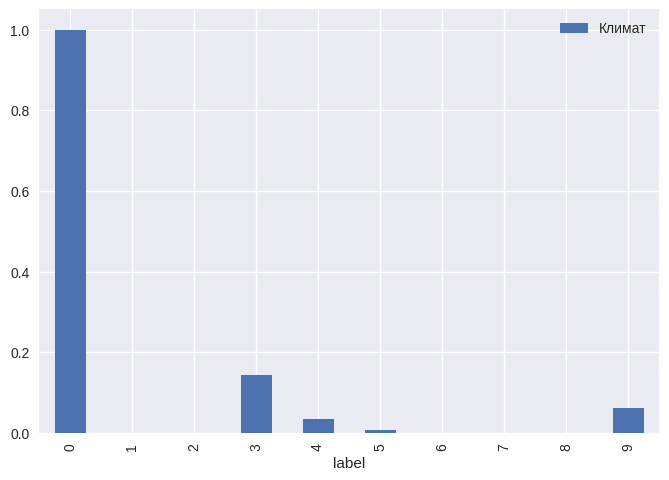

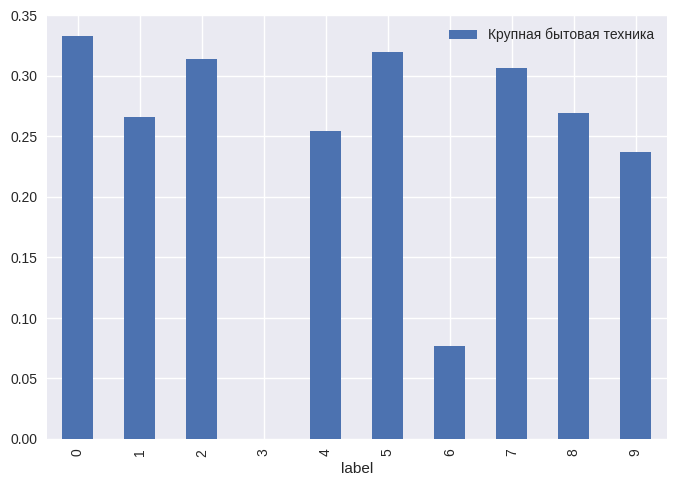

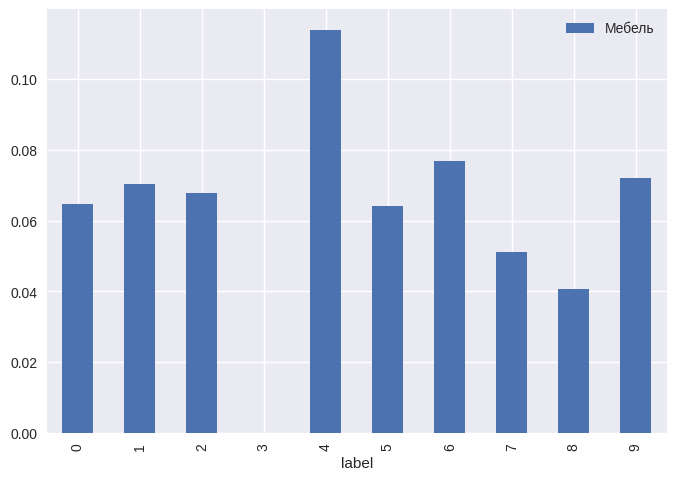

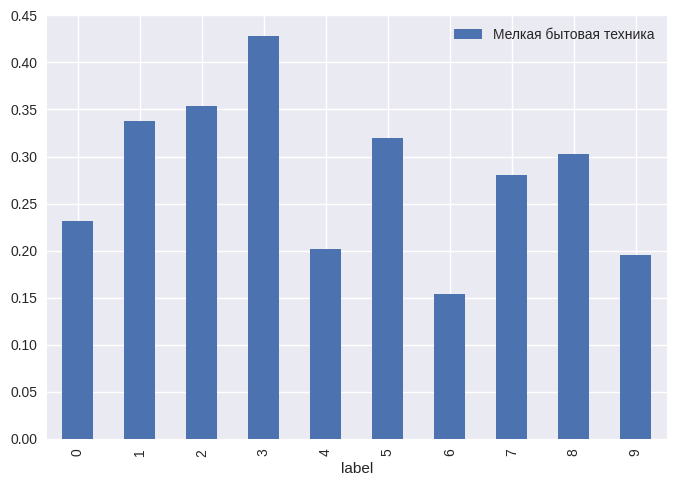

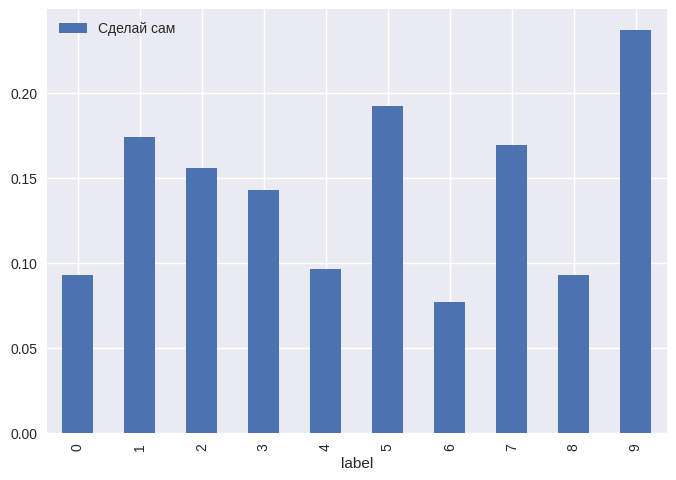

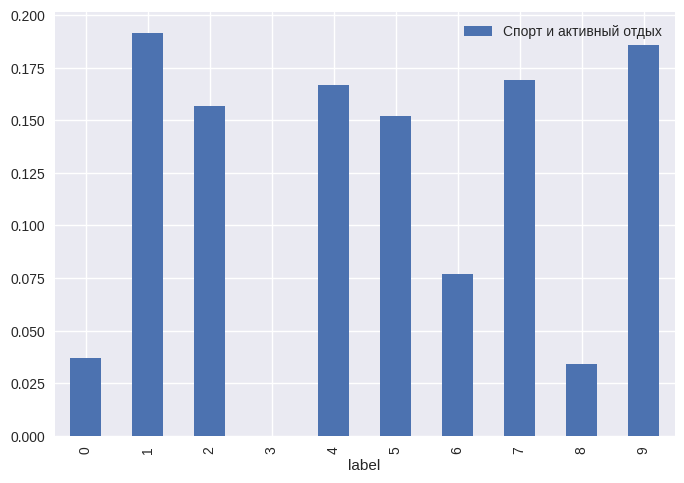

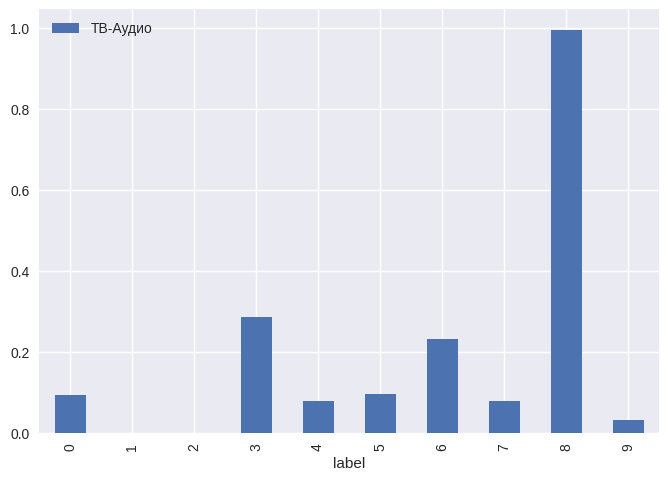

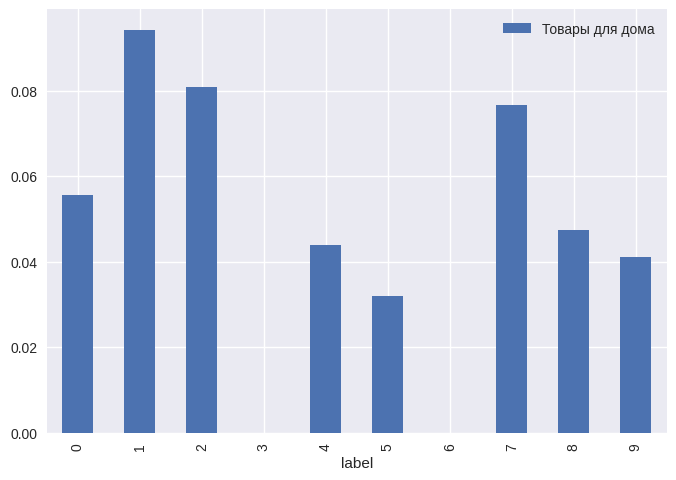

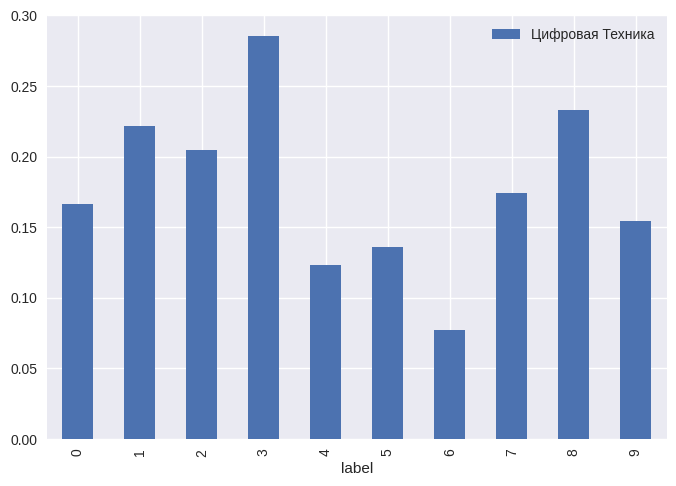

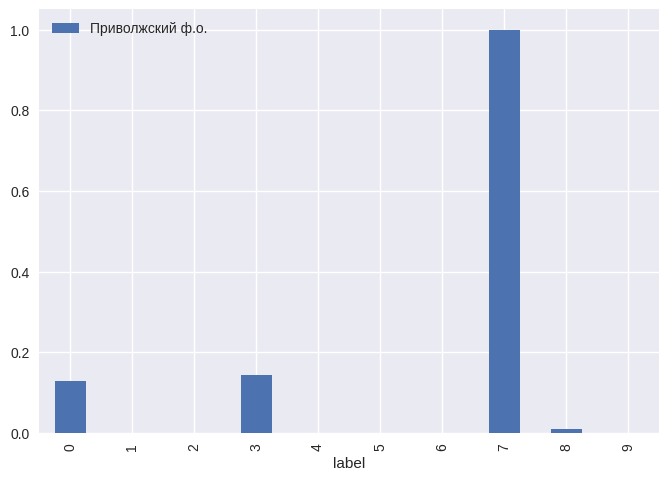

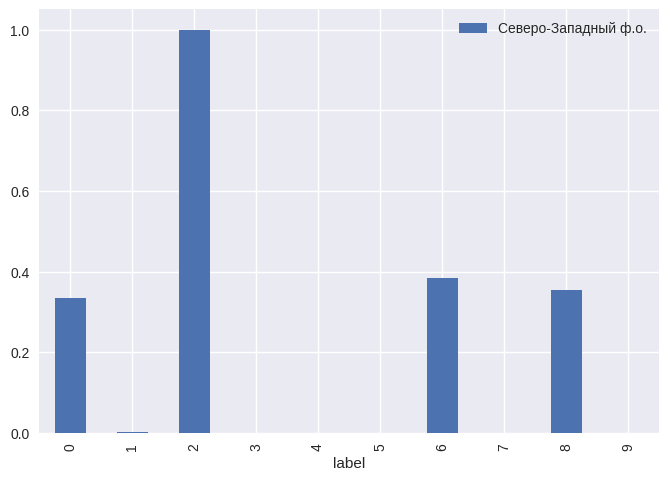

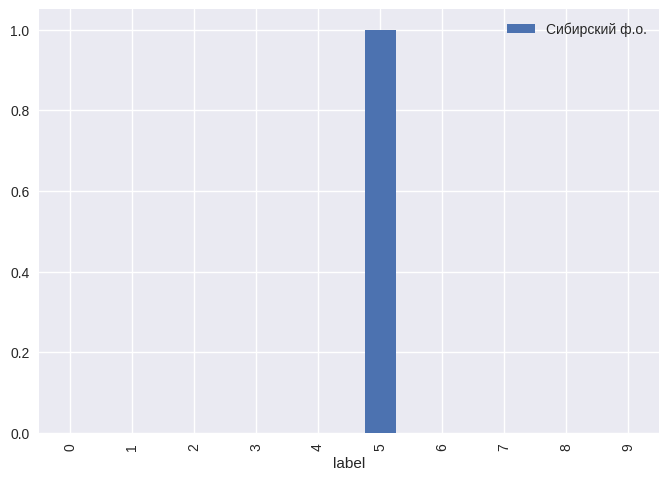

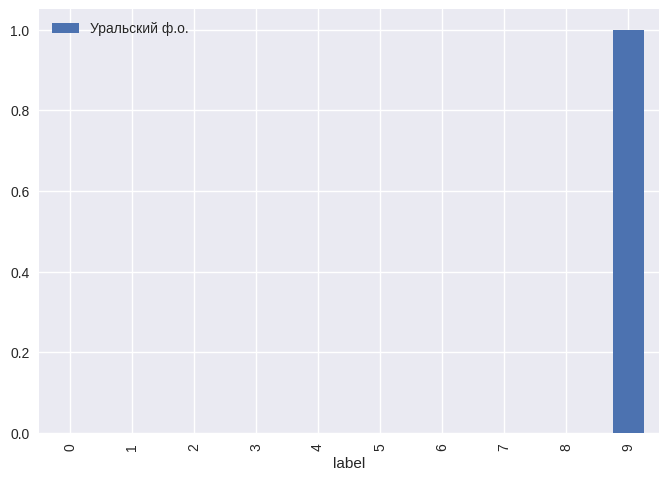

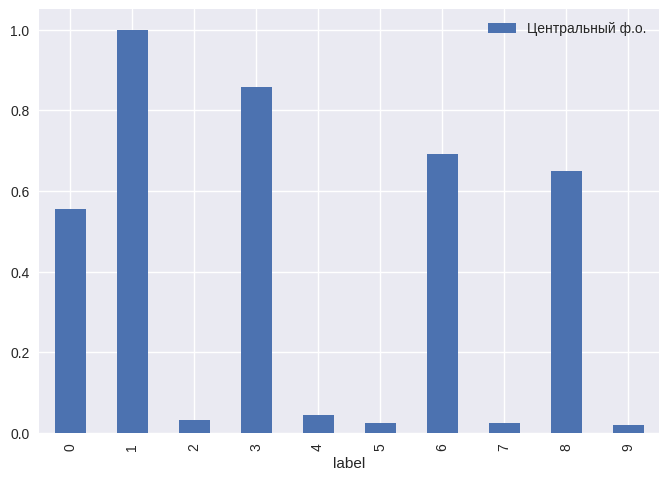

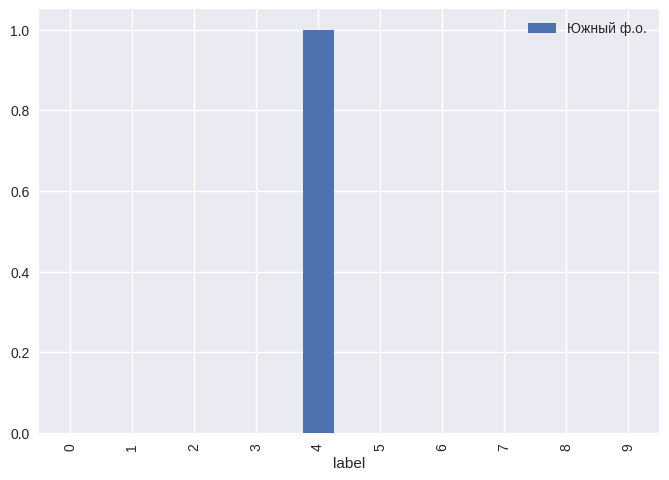

In [45]:
for col in cluster_df.columns:
    df_clients.groupby('label').mean().plot.bar(y=col)

In [46]:
# Оставим в выдаче только купиленные товары (отмененные не нужны)
df = df.loc[df['Status'] == 'Выдан клиенту']

tmp = df.groupby(['Phone_new', 'Order_ID', 'NomGroup'])['RowSum'].count().reset_index().groupby(['Phone_new', 'Order_ID'])['NomGroup'].count().reset_index()
phones = tmp.groupby('Phone_new')['Order_ID'].count()[tmp.groupby('Phone_new')['Order_ID'].count() > 2].index
df = df[df['Phone_new'].isin(phones)]

# Построение рекомендаций

In [98]:
df_rec = df.copy()
df_rec['datetime'] = pd.to_datetime(df_rec['OrderDate'] + ' ' + df_rec['время'])
df_rec['value'] = 1

In [99]:
last = df_rec.groupby('Phone_new')['datetime'].max().reset_index().set_index(['Phone_new', 'datetime'])
last_orders = df_rec.join(last, on=['Phone_new', 'datetime'], how='inner')
prev_orders = df_rec[~df_rec.index.isin(last_orders.index)]

In [100]:
from sklearn.model_selection import train_test_split


last_train, last_test = train_test_split(last_orders['Order_ID'].unique(), test_size=0.25, shuffle=True, random_state=8)

df_train = prev_orders.append(last_orders[last_orders['Order_ID'].isin(last_train)])
df_test = last_orders[last_orders['Order_ID'].isin(last_test)]

In [101]:
df_train = df_train.groupby(['Phone_new', 'NomGroup'])['value'].mean().reset_index()
df_test = df_test.groupby(['Phone_new', 'NomGroup'])['value'].mean().reset_index()

In [102]:
IDs_user = {y: x for x, y in enumerate(set(df_train['Phone_new']))}
IDs_item = {y: x for x, y in enumerate(set(df_train['NomGroup']))}

df_train['Phone_new'] = df_train['Phone_new'].map(IDs_user)
df_train['NomGroup'] = df_train['NomGroup'].map(IDs_item)
df_train.columns = ['user_id', 'item_id', 'value']

df_test['Phone_new'] = df_test['Phone_new'].map(IDs_user)
df_test['NomGroup'] = df_test['NomGroup'].map(IDs_item)
df_test.columns = ['user_id', 'item_id', 'value']
df_test

,user_id,item_id,value
0,293,75.0,1.0
1,463,308.0,1.0
2,246,98.0,1.0
3,1008,307.0,1.0
4,410,232.0,1.0
...,...,...,...
291,597,241.0,1.0
292,871,167.0,1.0
293,153,98.0,1.0
294,255,163.0,1.0


In [103]:
uid = list(set(df_train['user_id']))
iid = list(set(df_train['item_id']))

X_train = pd.DataFrame({'user_id' : sorted(uid * len(iid)), 'item_id' : iid * len(uid)})
X_train = X_train.join(df_train.set_index(['user_id', 'item_id']), on=['user_id', 'item_id'], how='outer', rsuffix='_').fillna(0.0)

uid = list(set(df_test['user_id']))
X_test = pd.DataFrame({'user_id' : sorted(uid * len(iid)), 'item_id' : iid * len(uid)})
X_test = X_test.join(df_test.set_index(['user_id', 'item_id']), on=['user_id', 'item_id'], how='outer', rsuffix='_').fillna(0.0)

In [104]:
clusters = df[['Phone_new', 'label']]
clusters['Phone_new'] = clusters['Phone_new'].map(IDs_user)
clusters = clusters.dropna()

X_train = X_train.set_index('user_id').join(clusters.set_index('Phone_new')).reset_index().dropna().rename(columns={"index": "user_id"})
X_test = X_test.set_index('user_id').join(clusters.set_index('Phone_new')).reset_index().dropna().rename(columns={"index": "user_id"})

In [105]:
print(X_train.shape, X_test.shape)

(2241120, 4) (559584, 4)


In [106]:
print('\tTrain\tTest')
for i in range(10):
    print(f"{i}\t{len(X_train[(X_train['label'] == i) & (X_train['value'] > 0)])}\t{len(X_test[(X_test['label'] == i) & (X_test['value'] > 0)])}")

	Train	Test
0	682	44
1	8805	660
2	3293	270
3	22	3
4	294	12
5	302	12
6	3	3
7	1302	125
8	3153	220
9	176	12


## Базовые методы колаборативной фильтрации

In [109]:
# !pip install surprise

In [108]:
from surprise import Reader, Dataset


reader = Reader(rating_scale=(0, 1))
data_train = Dataset.load_from_df(X_train[['user_id', 'item_id', 'value']], reader).build_full_trainset()
data_test = Dataset.load_from_df(X_test[['user_id', 'item_id', 'value']], reader).build_full_trainset().build_testset()

In [110]:
from surprise import accuracy, Dataset, SVD, SVDpp, NMF, SlopeOne, NormalPredictor, CoClustering, KNNWithMeans
from surprise.model_selection import train_test_split


algo = SVD(n_factors=20, n_epochs=20, lr_all=0.01, reg_all=0.01, verbose=False)
algo.fit(data_train)
SVD_pred = algo.test(data_test)
print('SVD')
accuracy.rmse(SVD_pred)
accuracy.mae(SVD_pred)
print()

algo = NMF(n_factors=20, n_epochs=20, reg_pu=0.01, reg_qi=0.01, reg_bu=0.01, reg_bi=0.01, lr_bu=0.01, lr_bi=0.01, verbose=False)
algo.fit(data_train)
NMF_pred = algo.test(data_test)
print('NMF')
accuracy.rmse(NMF_pred)
accuracy.mae(NMF_pred)
print()

algo = SlopeOne()
algo.fit(data_train)
SlopeOne_pred = algo.test(data_test)
print('Slope One')
accuracy.rmse(SlopeOne_pred)
accuracy.mae(SlopeOne_pred)
print()

algo = CoClustering(n_cltr_u=5, n_cltr_i=5, n_epochs=10, verbose=False)
algo.fit(data_train)
CoClustering_pred = algo.test(data_test)
print('Co-clustering')
accuracy.rmse(CoClustering_pred)
accuracy.mae(CoClustering_pred)
print()

algo = NormalPredictor()
algo.fit(data_train)
RandNorm_pred = algo.test(data_test)
print('Random')
accuracy.rmse(RandNorm_pred)
accuracy.mae(RandNorm_pred)
print()

SVD
RMSE: 0.0542
MAE:  0.0127

NMF
RMSE: 0.0508
MAE:  0.0047

Slope One
RMSE: 0.0544
MAE:  0.0108

Co-clustering
RMSE: 0.0536
MAE:  0.0092

Random
RMSE: 0.0827
MAE:  0.0420



In [111]:
from sklearn.metrics import average_precision_score


def get_df(pred):
    return pd.DataFrame({'user' : [p.uid for p in pred], 'item' : [p.iid for p in pred], 'value' : [p.r_ui for p in pred], 'pred' : [p.est for p in pred]})


def map_k(data):
    ap = []
    for i in tqdm(set(data['user'])):
        ap += [average_precision_score(data[data['user'] == i]['value'], data[data['user'] == i]['pred'])]
    return np.mean(ap)

In [112]:
res = pd.DataFrame({
    'Segment': 'ALL',
    'Random': [map_k(get_df(RandNorm_pred))],
    'SVD': [map_k(get_df(SVD_pred))],
    'NMF': [map_k(get_df(NMF_pred))],
    'Slope One': [map_k(get_df(SlopeOne_pred))],
    'Co-clustering': [map_k(get_df(CoClustering_pred))],
    'Train size': [len(X_train[X_train['value'] > 0])],
    'Test size': [len(X_test[X_test['value'] > 0])]
})

res

100%|██████████| 271/271 [00:01<00:00, 263.33it/s]


,Segment,Random,SVD,NMF,Slope One,Co-clustering,Train size,Test size
0,ALL,0.005648,0.105701,0.098139,0.07369,0.127842,18032,1361


## Рекомендации по сегментам

In [ ]:
# !pip install surprise

In [113]:
from sklearn.metrics import average_precision_score


def get_df(pred):
    return pd.DataFrame({'user' : [p.uid for p in pred], 'item' : [p.iid for p in pred], 'value' : [p.r_ui for p in pred], 'pred' : [p.est for p in pred]})


def map_k(data):
    ap = []
    for i in tqdm(set(data['user'])):
        ap += [average_precision_score(data[data['user'] == i]['value'], data[data['user'] == i]['pred'])]
    return np.mean(ap)

In [114]:
from surprise import Reader, Dataset
from surprise import accuracy, Dataset, SVD, SVDpp, NMF, SlopeOne, NormalPredictor, CoClustering, KNNWithMeans
from surprise.model_selection import train_test_split


def seg_rec(c):
    reader = Reader(rating_scale=(0, 1))
    data_train = Dataset.load_from_df(X_train[X_train['label'] == c][['user_id', 'item_id', 'value']], reader).build_full_trainset()
    data_test = Dataset.load_from_df(X_test[X_test['label'] == c][['user_id', 'item_id', 'value']], reader).build_full_trainset().build_testset()


    algo = SVD(n_factors=20, n_epochs=20, lr_all=0.01, reg_all=0.01, verbose=False)
    algo.fit(data_train)
    SVD_pred = algo.test(data_test)
    print('SVD')
    accuracy.rmse(SVD_pred)
    accuracy.mae(SVD_pred)
    print()

    algo = NMF(n_factors=20, n_epochs=20, reg_pu=0.01, reg_qi=0.01, reg_bu=0.01, reg_bi=0.01, lr_bu=0.01, lr_bi=0.01, verbose=False)
    algo.fit(data_train)
    NMF_pred = algo.test(data_test)
    print('NMF')
    accuracy.rmse(NMF_pred)
    accuracy.mae(NMF_pred)
    print()

    algo = SlopeOne()
    algo.fit(data_train)
    SlopeOne_pred = algo.test(data_test)
    print('Slope One')
    accuracy.rmse(SlopeOne_pred)
    accuracy.mae(SlopeOne_pred)
    print()

    algo = CoClustering(n_cltr_u=5, n_cltr_i=5, n_epochs=10, verbose=False)
    algo.fit(data_train)
    CoClustering_pred = algo.test(data_test)
    print('Co-clustering')
    accuracy.rmse(CoClustering_pred)
    accuracy.mae(CoClustering_pred)
    print()

    algo = NormalPredictor()
    algo.fit(data_train)
    RandNorm_pred = algo.test(data_test)
    print('Random')
    accuracy.rmse(RandNorm_pred)
    accuracy.mae(RandNorm_pred)
    print()


    return [
        c,
        map_k(get_df(RandNorm_pred)),
        map_k(get_df(SVD_pred)),
        map_k(get_df(NMF_pred)),
        map_k(get_df(SlopeOne_pred)),
        map_k(get_df(CoClustering_pred)),
        len(X_train[(X_train['label'] == c) & (X_train['value'] > 0)]),
        len(X_test[(X_test['label'] == c) & (X_test['value'] > 0)])
    ]


res_seg = res.copy()
for i in set(X_train['label']):
    res_seg.loc[len(res_seg)] = seg_rec(i)
res_seg

SVD
RMSE: 0.0529
MAE:  0.0103

NMF
RMSE: 0.0547
MAE:  0.0066

Slope One
RMSE: 0.0671
MAE:  0.0127

Co-clustering
RMSE: 0.0543
MAE:  0.0088

Random
RMSE: 0.0822
MAE:  0.0428



100%|██████████| 10/10 [00:00<00:00, 385.83it/s]


SVD
RMSE: 0.0552
MAE:  0.0124

NMF
RMSE: 0.0521
MAE:  0.0048

Slope One
RMSE: 0.0580
MAE:  0.0118

Co-clustering
RMSE: 0.0545
MAE:  0.0095

Random
RMSE: 0.0847
MAE:  0.0430



100%|██████████| 119/119 [00:00<00:00, 327.91it/s]


SVD
RMSE: 0.0566
MAE:  0.0175

NMF
RMSE: 0.0510
MAE:  0.0042

Slope One
RMSE: 0.0549
MAE:  0.0099

Co-clustering
RMSE: 0.0541
MAE:  0.0096

Random
RMSE: 0.0812
MAE:  0.0409



100%|██████████| 54/54 [00:00<00:00, 380.52it/s]


SVD
RMSE: 0.0515
MAE:  0.0062

NMF
RMSE: 0.0372
MAE:  0.0023

Slope One
RMSE: 0.0683
MAE:  0.0076

Co-clustering
RMSE: 0.0464
MAE:  0.0022

Random
RMSE: 0.0726
MAE:  0.0355



100%|██████████| 1/1 [00:00<00:00, 178.47it/s]


SVD
RMSE: 0.0527
MAE:  0.0101

NMF
RMSE: 0.0527
MAE:  0.0046

Slope One
RMSE: 0.0624
MAE:  0.0107

Co-clustering
RMSE: 0.0520
MAE:  0.0078

Random
RMSE: 0.0802
MAE:  0.0413



100%|██████████| 4/4 [00:00<00:00, 361.62it/s]


SVD
RMSE: 0.0518
MAE:  0.0094

NMF
RMSE: 0.0478
MAE:  0.0031

Slope One
RMSE: 0.0521
MAE:  0.0088

Co-clustering
RMSE: 0.0521
MAE:  0.0076

Random
RMSE: 0.0759
MAE:  0.0383



100%|██████████| 4/4 [00:00<00:00, 313.19it/s]


SVD
RMSE: 0.0254
MAE:  0.0018

NMF
RMSE: 0.0100
MAE:  0.0005

Slope One
RMSE: 0.0000
MAE:  0.0000

Co-clustering
RMSE: 0.0000
MAE:  0.0000

Random
RMSE: 0.0573
MAE:  0.0213



100%|██████████| 1/1 [00:00<00:00, 186.70it/s]


SVD
RMSE: 0.0515
MAE:  0.0150

NMF
RMSE: 0.0487
MAE:  0.0051

Slope One
RMSE: 0.0490
MAE:  0.0096

Co-clustering
RMSE: 0.0527
MAE:  0.0094

Random
RMSE: 0.0769
MAE:  0.0387



100%|██████████| 25/25 [00:00<00:00, 407.78it/s]


SVD
RMSE: 0.0523
MAE:  0.0114

NMF
RMSE: 0.0529
MAE:  0.0073

Slope One
RMSE: 0.0538
MAE:  0.0121

Co-clustering
RMSE: 0.0574
MAE:  0.0103

Random
RMSE: 0.0840
MAE:  0.0436



100%|██████████| 50/50 [00:00<00:00, 334.51it/s]


SVD
RMSE: 0.0506
MAE:  0.0094

NMF
RMSE: 0.0552
MAE:  0.0048

Slope One
RMSE: 0.0528
MAE:  0.0085

Co-clustering
RMSE: 0.0610
MAE:  0.0087

Random
RMSE: 0.0745
MAE:  0.0362



100%|██████████| 3/3 [00:00<00:00, 195.24it/s]


,Segment,Random,SVD,NMF,Slope One,Co-clustering,Train size,Test size
0,ALL,0.005648,0.105701,0.098139,0.073690,0.127842,18032.0,1361.0
1,0.0,0.008101,0.124531,0.221366,0.029107,0.081535,682.0,44.0
2,1.0,0.004082,0.079647,0.109396,0.055535,0.110317,8805.0,660.0
3,2.0,0.005434,0.118376,0.133854,0.100036,0.122580,3293.0,270.0
4,3.0,0.004821,0.200000,1.000000,0.166667,0.500000,22.0,3.0
5,4.0,0.005393,0.007714,0.013521,0.006718,0.015505,294.0,12.0
6,5.0,0.005074,0.013521,0.019474,0.012486,0.029422,302.0,12.0
7,6.0,0.002077,1.000000,1.000000,1.000000,1.000000,3.0,3.0
8,7.0,0.004800,0.186872,0.263178,0.125408,0.177742,1302.0,125.0
9,8.0,0.005303,0.356684,0.275714,0.332948,0.266526,3153.0,220.0


In [115]:
res_seg.append(pd.DataFrame(
    [['ALL_SEG'] + list(res_seg.iloc[1:, 1:-2].mul(res_seg.iloc[1:]['Test size'], axis=0).sum() / res_seg.iloc[0]['Test size']) + [res_seg.iloc[0]['Train size'], res_seg.iloc[0]['Test size']]], 
     columns=res_seg.columns
), ignore_index=True)

,Segment,Random,SVD,NMF,Slope One,Co-clustering,Train size,Test size
0,ALL,0.005648,0.105701,0.098139,0.073690,0.127842,18032.0,1361.0
1,0.0,0.008101,0.124531,0.221366,0.029107,0.081535,682.0,44.0
2,1.0,0.004082,0.079647,0.109396,0.055535,0.110317,8805.0,660.0
3,2.0,0.005434,0.118376,0.133854,0.100036,0.122580,3293.0,270.0
4,3.0,0.004821,0.200000,1.000000,0.166667,0.500000,22.0,3.0
5,4.0,0.005393,0.007714,0.013521,0.006718,0.015505,294.0,12.0
6,5.0,0.005074,0.013521,0.019474,0.012486,0.029422,302.0,12.0
7,6.0,0.002077,1.000000,1.000000,1.000000,1.000000,3.0,3.0
8,7.0,0.004800,0.186872,0.263178,0.125408,0.177742,1302.0,125.0
9,8.0,0.005303,0.356684,0.275714,0.332948,0.266526,3153.0,220.0


# Sequential models

In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F

Представим товары, как слова, а заказы как предложения. "Предложения" резделим токеном \<SEP\>

In [48]:
df['datetime'] = pd.to_datetime(df['OrderDate'] + ' ' + df['время'])
df_seq = df.groupby(['Phone_new', 'datetime',  'Order_ID'])['NomGroup'].apply(lambda x: list(x)).reset_index()
df_seq = df_seq.groupby(['Phone_new'])[['datetime', 'NomGroup']].apply(lambda x: [['<CLS>']] + [v + ['<SEP>'] for v in x.sort_values(by=['datetime'])['NomGroup']]).reset_index()
df_seq[0] = df_seq[0].apply(lambda x: [product for order in x for product in order][:-1])
df_seq.columns = ['Phone_new', 'orders']
df_seq['last_sep'] = df_seq['orders'].apply(lambda x: len(x) - x[::-1].index('<SEP>') - 1)

In [49]:
# Токенизируем
tk2num = {v: i + 5 for i, v in enumerate(set(df['NomGroup']))}
tk2num['<PAD>'] = 0
tk2num['<CLS>'] = 1
tk2num['<SEP>'] = 2
tk2num['<UNK>'] = 3
tk2num['<MASK>'] = 4
num2tk = {v: k for k, v in tk2num.items()}

df_seq['tokens'] = df_seq['orders'].apply(lambda x: [tk2num[i] for i in x])

In [50]:
# Возьмем последний заказ за целевую переменную
X = []
y = []
for i in range(len(df_seq)):
    X += [df_seq['tokens'].iloc[i][:df_seq['last_sep'].iloc[i] + 1]]   
    y += [df_seq['tokens'].iloc[i][df_seq['last_sep'].iloc[i] + 1:]]
df_seq['X'] = X
df_seq['y'] = y

In [51]:
# Добавим сегменты
df_seq = df_seq.join(df[['Phone_new', 'label']].groupby('Phone_new').max(), on='Phone_new', how='inner')
df_seq

,Phone_new,orders,last_sep,tokens,X,y,label
0,55555555-51535356545777,"[<CLS>, Кронштейны для телевизоров, <SEP>, 3D...",4,"[1, 209, 2, 383, 2, 211]","[1, 209, 2, 383, 2]",[211],8
1,55574848-485051575051755,"[<CLS>, Внешние жесткие диски, <SEP>, Подставк...",8,"[1, 14, 2, 157, 2, 109, 2, 151, 2, 83]","[1, 14, 2, 157, 2, 109, 2, 151, 2]",[83],2
2,55574848-50565454514879,"[<CLS>, Утюги, <SEP>, Стиральные машины, <SEP>...",20,"[1, 388, 2, 210, 2, 175, 2, 210, 2, 355, 2, 35...","[1, 388, 2, 210, 2, 175, 2, 210, 2, 355, 2, 35...","[100, 244]",1
3,55574848-515049575152715,"[<CLS>, Блендеры, <SEP>, Велосипеды, <SEP>, Ве...",4,"[1, 184, 2, 77, 2, 77]","[1, 184, 2, 77, 2]",[77],2
4,55574848-515450495555755,"[<CLS>, Крепления для беговых лыж, <SEP>, Бего...",6,"[1, 325, 2, 125, 325, 29, 2, 325]","[1, 325, 2, 125, 325, 29, 2]",[325],2
...,...,...,...,...,...,...,...
1076,55575750-48485552565176,"[<CLS>, Грифы, Диски, <SEP>, Диски, Грифы, <SE...",6,"[1, 183, 143, 2, 143, 183, 2, 143]","[1, 183, 143, 2, 143, 183, 2]",[143],7
1077,55575750-50485152564871,"[<CLS>, Электрические духовые шкафы, Встраивае...",9,"[1, 451, 424, 353, 369, 101, 2, 369, 451, 2, 353]","[1, 451, 424, 353, 369, 101, 2, 369, 451, 2]",[353],7
1078,55575757-49545050495571,"[<CLS>, Холодильники, <SEP>, Аксессуары для са...",5,"[1, 175, 2, 286, 286, 2, 166]","[1, 175, 2, 286, 286, 2]",[166],7
1079,55575757-54545448494874,"[<CLS>, Машинки для стрижки волос, <SEP>, Для ...",5,"[1, 100, 2, 436, 458, 2, 425]","[1, 100, 2, 436, 458, 2]",[425],4


## GRU4Rec

In [86]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df_seq[['tokens']], test_size=0.25, shuffle=True)

In [87]:
def split_array(arr, value):
    result = []
    sublist = []
    for num in arr:
        if num == value:
            if sublist:
                result.append(sublist)
                sublist = []
        else:
            sublist.append(num)
    if sublist:
        result.append(sublist)
    return result


def orders(arr):
    result = []
    for basket in arr:
        z = np.zeros(len(tk2num))
        z[basket] = 1
        result += [z]
    return np.array(result)

In [88]:
MAX_SEQ_LEN = 200

In [89]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, batch_size):
        df = data.copy()
        df['tokens'] = df['tokens'].apply(lambda x: [1] + x[1 - MAX_SEQ_LEN:] if len(x) > MAX_SEQ_LEN else x)
        df['tokens'] = df['tokens'].apply(lambda x: split_array(x, tk2num['<SEP>']))
        self.batches = []
        df['sz'] = df['tokens'].apply(lambda x: len(x))
        df = df.sort_values(by=['sz'], ascending=False)
        for i in range(len(df)):
            if i % batch_size != 0:
                Z = np.zeros((len(self.batches[-1][0]), len(tk2num)))
                seq = orders(df['tokens'].iloc[i])
                Z[:len(seq)] = seq
                self.batches[-1] += [Z[:, 5:].tolist()]
            else:
                Z = orders(df['tokens'].iloc[i])
                self.batches += [[Z[:, 5:].tolist()]]
        
    def __len__(self):
        return len(self.batches)
    
    def __getitem__(self, idx):
        vecs = np.array(self.batches[idx])
        pad = np.array(self.batches[idx]).max(axis=2) == 0
        return vecs[:, :-1, :], vecs[:, 1:, :], pad[:, 1:]

In [90]:
BATCH_SIZE = 32

train_dataset = Dataset(df_train, batch_size=BATCH_SIZE)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)

test_dataset = Dataset(df_test, batch_size=BATCH_SIZE)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

### Train

In [96]:
from GRU4Rec import GRU4Rec


model = GRU4Rec(
    num_items= len(tk2num)-5,
    embed_size=64,
    num_blocks=4,
    d_ff=128,
    output_sz=len(tk2num)-5,
    dropout_prob=0.1
)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3) #, weight_decay=0.01
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

GRU4Rec(
  (gru): GRU(478, 64, num_layers=4, batch_first=True, dropout=0.1)
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=478, bias=True)
)

In [97]:
from sklearn.metrics import average_precision_score


def map_score(y_true, y_pred):
    ap = []
    for i in range(len(y_true)):
        ap += [average_precision_score(y_true[i], y_pred[i])]
    return ap, np.mean(ap)


EPOCHS = 30


for n in range(EPOCHS):
    model.train()
    ap = []
    pbar = tqdm(train_dataloader, desc=f'Train epoch {n + 1}')
    for X, y, pad in pbar:
        X, y, pad = X[0], y[0], pad[0]

        optimizer.zero_grad()
        # строим предсказания
        pred, _ = model(X.float().to(device))

        # считаем ошибку и корректируем веса
        last = torch.zeros((pad.shape[0], pad.shape[1] + 1)) == 0
        last[:, :-1] = pad
        last[:, :-1] ^= last[:, 1:]
        last = last[:, :-1]
        
        loss = criterion(pred[last], y[last].to(device))
        loss.backward()
        optimizer.step()

        # сохраняем результаты для рассчета метрик
        batch_ap, batch_map = map_score(y[last].cpu().detach().numpy(), pred[last].cpu().detach().numpy())
        ap += batch_ap
        pbar.set_postfix({'loss': loss.item(), 'batch_map': batch_map, 'map': np.mean(ap)})
    

    model.eval()
    with torch.no_grad():
        ap = []
        pbar = tqdm(test_dataloader, desc=f'Test epoch {n + 1}')
        for X, y, pad in pbar:
            X, y, pad = X[0], y[0], pad[0]

            # строим предсказания
            pred, _ = model(X.float().to(device))

            # сохраняем результаты для рассчета метрик
            last = torch.zeros((pad.shape[0], pad.shape[1] + 1)) == 0
            last[:, :-1] = pad
            last[:, :-1] ^= last[:, 1:]
            last = last[:, :-1]

            batch_ap, batch_map = map_score(y[last].cpu().detach().numpy(), pred[last].cpu().detach().numpy())
            ap += batch_ap
            pbar.set_postfix({'loss': loss.item(), 'batch_map': batch_map, 'map': np.mean(ap)})
    
    print()

Test epoch 1: 100%|██████████| 9/9 [00:00<00:00, 20.99it/s, loss=6.35, batch_map=0.0977, map=0.0808]


Test epoch 2: 100%|██████████| 9/9 [00:00<00:00, 21.52it/s, loss=6.53, batch_map=0.136, map=0.104]


Test epoch 3: 100%|██████████| 9/9 [00:00<00:00, 20.39it/s, loss=4.98, batch_map=0.0729, map=0.103]


Test epoch 4: 100%|██████████| 9/9 [00:00<00:00, 13.85it/s, loss=5.57, batch_map=0.127, map=0.1]


Test epoch 5: 100%|██████████| 9/9 [00:00<00:00, 13.51it/s, loss=5.58, batch_map=0.164, map=0.103]


Test epoch 6: 100%|██████████| 9/9 [00:00<00:00, 21.97it/s, loss=4.8, batch_map=0.174, map=0.101]


Test epoch 7: 100%|██████████| 9/9 [00:00<00:00, 21.49it/s, loss=5.92, batch_map=0.149, map=0.101]


Test epoch 8: 100%|██████████| 9/9 [00:00<00:00, 21.93it/s, loss=4.68, batch_map=0.0261, map=0.0998]


Test epoch 9: 100%|██████████| 9/9 [00:00<00:00, 21.17it/s, loss=4.68, batch_map=0.0265, map=0.0824]


Test epoch 10: 100%|██████████| 9/9 [00:00<00:00, 21.82it/s, loss=4.71, batch_map=0.11, map=0.0941]


Test epoch 11: 100%|██████████| 9/9 [00:00<00:00, 16.35it/s, loss=4.61, batch_map=0.0929, map=0.101]


Test epoch 12: 100%|██████████| 9/9 [00:00<00:00, 13.32it/s, loss=5.33, batch_map=0.0209, map=0.103]


Test epoch 13: 100%|██████████| 9/9 [00:00<00:00, 20.75it/s, loss=4.86, batch_map=0.107, map=0.114]


Test epoch 14: 100%|██████████| 9/9 [00:00<00:00, 21.03it/s, loss=5.23, batch_map=0.101, map=0.0844]


Test epoch 15: 100%|██████████| 9/9 [00:00<00:00, 21.59it/s, loss=4.37, batch_map=0.129, map=0.111]


Test epoch 16: 100%|██████████| 9/9 [00:00<00:00, 21.28it/s, loss=5.19, batch_map=0.101, map=0.116]


Test epoch 17: 100%|██████████| 9/9 [00:00<00:00, 22.16it/s, loss=4.62, batch_map=0.0566, map=0.112]


Test epoch 18: 100%|██████████| 9/9 [00:00<00:00, 21.74it/s, loss=4.8, batch_map=0.126, map=0.116]


Test epoch 19: 100%|██████████| 9/9 [00:00<00:00, 13.75it/s, loss=5.21, batch_map=0.113, map=0.0994]


Test epoch 20: 100%|██████████| 9/9 [00:00<00:00, 19.55it/s, loss=4.74, batch_map=0.034, map=0.115]


Test epoch 21: 100%|██████████| 9/9 [00:00<00:00, 21.24it/s, loss=4.92, batch_map=0.0467, map=0.111]


Test epoch 22: 100%|██████████| 9/9 [00:00<00:00, 22.37it/s, loss=5.18, batch_map=0.0898, map=0.11]


Test epoch 23: 100%|██████████| 9/9 [00:00<00:00, 21.60it/s, loss=5.48, batch_map=0.106, map=0.121]


Test epoch 24: 100%|██████████| 9/9 [00:00<00:00, 21.05it/s, loss=4.42, batch_map=0.114, map=0.112]


Test epoch 25: 100%|██████████| 9/9 [00:00<00:00, 20.66it/s, loss=4.28, batch_map=0.199, map=0.111]


Test epoch 26: 100%|██████████| 9/9 [00:00<00:00, 14.13it/s, loss=4.79, batch_map=0.0817, map=0.106]


Test epoch 27: 100%|██████████| 9/9 [00:00<00:00, 13.41it/s, loss=4.08, batch_map=0.117, map=0.112]


Test epoch 28: 100%|██████████| 9/9 [00:00<00:00, 21.40it/s, loss=4.15, batch_map=0.143, map=0.113]


Test epoch 29: 100%|██████████| 9/9 [00:00<00:00, 21.39it/s, loss=5.16, batch_map=0.122, map=0.137]


Test epoch 30: 100%|██████████| 9/9 [00:00<00:00, 21.79it/s, loss=3.74, batch_map=0.0967, map=0.127]

## SASRec

In [62]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df_seq[['tokens']], test_size=0.25, shuffle=True)

In [63]:
def split_array(arr, value):
    result = []
    sublist = []
    for num in arr:
        if num == value:
            if sublist:
                result.append(sublist)
                sublist = []
        else:
            sublist.append(num)
    if sublist:
        result.append(sublist)
    return result


def orders(arr):
    result = []
    for basket in arr:
        z = np.zeros(len(tk2num))
        z[basket] = 1
        result += [z]
    return np.array(result)

In [64]:
MAX_SEQ_LEN = 200

In [65]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, batch_size):
        df = data.copy()
        df['tokens'] = df['tokens'].apply(lambda x: [1] + x[1 - MAX_SEQ_LEN:] if len(x) > MAX_SEQ_LEN else x)
        df['tokens'] = df['tokens'].apply(lambda x: split_array(x, tk2num['<SEP>']))
        self.batches = []
        df['sz'] = df['tokens'].apply(lambda x: len(x))
        df = df.sort_values(by=['sz'], ascending=False)
        for i in range(len(df)):
            if i % batch_size != 0:
                Z = np.zeros((len(self.batches[-1][0]), len(tk2num)))
                seq = orders(df['tokens'].iloc[i])
                Z[:len(seq)] = seq
                self.batches[-1] += [Z[:, 5:].tolist()]
            else:
                Z = orders(df['tokens'].iloc[i])
                self.batches += [[Z[:, 5:].tolist()]]
        
    def __len__(self):
        return len(self.batches)
    
    def __getitem__(self, idx):
        vecs = np.array(self.batches[idx])
        pad = np.array(self.batches[idx]).max(axis=2) == 0
        return vecs[:, :-1, :], vecs[:, 1:, :], pad[:, 1:]

In [66]:
BATCH_SIZE = 32

train_dataset = Dataset(df_train, batch_size=BATCH_SIZE)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)

test_dataset = Dataset(df_test, batch_size=BATCH_SIZE)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

### Train

In [69]:
from SASRec import SASRec


model = SASRec(
    num_items= len(tk2num)-5,
    embed_size=128,
    max_seq_length=MAX_SEQ_LEN,
    num_heads=4,
    num_blocks=4,
    d_ff=256,
    output_sz=len(tk2num)-5,
    dropout_prob=0.1
)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3) #, weight_decay=0.01
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

SASRec(
  (item_embedding): Linear(in_features=478, out_features=128, bias=True)
  (positional_embedding): Embedding(200, 128)
  (attention_blocks): ModuleList(
    (0-3): 4 x TransformerBlock(
      (self_attention): MultiHeadAttention(
        (W_q): Linear(in_features=128, out_features=128, bias=True)
        (W_k): Linear(in_features=128, out_features=128, bias=True)
        (W_v): Linear(in_features=128, out_features=128, bias=True)
        (W_o): Linear(in_features=128, out_features=128, bias=True)
      )
      (layer_norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (feed_forward): Sequential(
        (0): Linear(in_features=128, out_features=256, bias=True)
        (1): ReLU()
        (2): Linear(in_features=256, out_features=128, bias=True)
      )
      (layer_norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (fc): Linear(in_features=128, out_features=478, bias=True)
)

In [70]:
from sklearn.metrics import average_precision_score


def map_score(y_true, y_pred):
    ap = []
    for i in range(len(y_true)):
        ap += [average_precision_score(y_true[i], y_pred[i])]
    return ap, np.mean(ap)


EPOCHS = 30


for n in range(EPOCHS):
    model.train()
    ap = []
    pbar = tqdm(train_dataloader, desc=f'Train epoch {n + 1}')
    for X, y, pad in pbar:
        X, y, pad = X[0], y[0], pad[0]

        optimizer.zero_grad()
        # строим предсказания
        pred = model(X.float().to(device))

        # считаем ошибку и корректируем веса
        loss = criterion(pred[~pad], y[~pad].to(device))
        loss.backward()
        optimizer.step()

        # сохраняем результаты для рассчета метрик
        last = torch.zeros((pad.shape[0], pad.shape[1] + 1)) == 0
        last[:, :-1] = pad
        last[:, :-1] ^= last[:, 1:]
        last = last[:, :-1]

        pred[last].cpu().detach().numpy()
        batch_ap, batch_map = map_score(y[last].cpu().detach().numpy(), pred[last].cpu().detach().numpy())
        ap += batch_ap
        pbar.set_postfix({'loss': loss.item(), 'batch_map': batch_map, 'map': np.mean(ap)})
    

    model.eval()
    with torch.no_grad():
        ap = []
        pbar = tqdm(test_dataloader, desc=f'Test epoch {n + 1}')
        for X, y, pad in pbar:
            X, y, pad = X[0], y[0], pad[0]

            # строим предсказания
            pred = model(X.float().to(device))

            # сохраняем результаты для рассчета метрик
            last = torch.zeros((pad.shape[0], pad.shape[1] + 1)) == 0
            last[:, :-1] = pad
            last[:, :-1] ^= last[:, 1:]
            last = last[:, :-1]

            batch_ap, batch_map = map_score(y[last].cpu().detach().numpy(), pred[last].cpu().detach().numpy())
            ap += batch_ap
            pbar.set_postfix({'loss': loss.item(), 'batch_map': batch_map, 'map': np.mean(ap)})
    
    print()

Test epoch 1: 100%|██████████| 9/9 [00:00<00:00, 10.46it/s, loss=6.3, batch_map=0.0957, map=0.0735]


Test epoch 2: 100%|██████████| 9/9 [00:00<00:00, 18.69it/s, loss=5.99, batch_map=0.129, map=0.082]


Test epoch 3: 100%|██████████| 9/9 [00:00<00:00, 18.40it/s, loss=5.89, batch_map=0.0601, map=0.0817]


Test epoch 4: 100%|██████████| 9/9 [00:00<00:00, 17.88it/s, loss=6.18, batch_map=0.051, map=0.0875]


Test epoch 5: 100%|██████████| 9/9 [00:00<00:00, 18.30it/s, loss=4.97, batch_map=0.0518, map=0.0866]


Test epoch 6: 100%|██████████| 9/9 [00:00<00:00, 12.42it/s, loss=5.93, batch_map=0.12, map=0.0829]


Test epoch 7: 100%|██████████| 9/9 [00:00<00:00, 12.06it/s, loss=5.82, batch_map=0.028, map=0.0916]


Test epoch 8: 100%|██████████| 9/9 [00:00<00:00, 20.00it/s, loss=4.95, batch_map=0.0536, map=0.0892]


Test epoch 9: 100%|██████████| 9/9 [00:00<00:00, 19.43it/s, loss=6.21, batch_map=0.116, map=0.0878]


Test epoch 10: 100%|██████████| 9/9 [00:00<00:00, 18.51it/s, loss=6.03, batch_map=0.125, map=0.0859]


Test epoch 11: 100%|██████████| 9/9 [00:00<00:00, 19.52it/s, loss=5.3, batch_map=0.0423, map=0.0787]


Test epoch 12: 100%|██████████| 9/9 [00:00<00:00, 12.49it/s, loss=5.76, batch_map=0.034, map=0.0881]


Test epoch 13: 100%|██████████| 9/9 [00:00<00:00, 12.83it/s, loss=5.61, batch_map=0.0488, map=0.0855]


Test epoch 14: 100%|██████████| 9/9 [00:00<00:00, 19.99it/s, loss=5.25, batch_map=0.0438, map=0.0938]


Test epoch 15: 100%|██████████| 9/9 [00:00<00:00, 19.97it/s, loss=4.87, batch_map=0.178, map=0.14]


Test epoch 16: 100%|██████████| 9/9 [00:00<00:00, 19.21it/s, loss=4.38, batch_map=0.152, map=0.115]


Test epoch 17: 100%|██████████| 9/9 [00:00<00:00, 19.73it/s, loss=4.69, batch_map=0.174, map=0.136]


Test epoch 18: 100%|██████████| 9/9 [00:00<00:00, 13.36it/s, loss=4.45, batch_map=0.165, map=0.153]


Test epoch 19: 100%|██████████| 9/9 [00:00<00:00, 20.10it/s, loss=4.29, batch_map=0.154, map=0.158]


Test epoch 20: 100%|██████████| 9/9 [00:00<00:00, 20.01it/s, loss=3.62, batch_map=0.144, map=0.161]


Test epoch 21: 100%|██████████| 9/9 [00:00<00:00, 18.19it/s, loss=3.64, batch_map=0.136, map=0.182]


Test epoch 22: 100%|██████████| 9/9 [00:00<00:00, 20.24it/s, loss=3.72, batch_map=0.17, map=0.15]


Test epoch 23: 100%|██████████| 9/9 [00:00<00:00, 18.97it/s, loss=2.61, batch_map=0.152, map=0.176]


Test epoch 24: 100%|██████████| 9/9 [00:00<00:00, 13.44it/s, loss=2.6, batch_map=0.166, map=0.18]


Test epoch 25: 100%|██████████| 9/9 [00:00<00:00, 19.81it/s, loss=2.7, batch_map=0.171, map=0.192]


Test epoch 26: 100%|██████████| 9/9 [00:00<00:00, 19.08it/s, loss=1.89, batch_map=0.135, map=0.167]


Test epoch 27: 100%|██████████| 9/9 [00:00<00:00, 19.36it/s, loss=2.37, batch_map=0.153, map=0.193]


Test epoch 28: 100%|██████████| 9/9 [00:00<00:00, 18.89it/s, loss=3.02, batch_map=0.344, map=0.177]


Test epoch 29: 100%|██████████| 9/9 [00:00<00:00, 19.41it/s, loss=2.47, batch_map=0.159, map=0.19]


Test epoch 30: 100%|██████████| 9/9 [00:00<00:00, 13.15it/s, loss=0.984, batch_map=0.108, map=0.185]

## BERT

In [71]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df_seq[['X', 'y', 'label']], test_size=0.25, shuffle=True)

In [72]:
MAX_SEQ_LEN = 200

In [73]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, batch_size):
        df = data.copy()
        df['X'] = df['X'].apply(lambda x: [1] + x[1 - MAX_SEQ_LEN:] if len(x) > MAX_SEQ_LEN else x)
        self.batches_X = []
        self.batches_y = []
        self.batches_seg = []
        df['sz'] = df['X'].apply(lambda x: len(x))
        df = df.sort_values(by=['sz'], ascending=False)
        for i in range(len(df)):
            z = np.zeros(len(tk2num))
            z[df['y'].iloc[i]] = 1
            s = np.zeros(10)
            s[df['label'].iloc[i]] = 1
            if i % batch_size != 0:
                self.batches_X[-1] += [df['X'].iloc[i] + [0] * (len(self.batches_X[-1][0]) - len(df['X'].iloc[i]))]
                self.batches_y[-1] += [list(z[5:])]
                self.batches_seg[-1] += [list(s)]
            else:
                self.batches_X += [[df['X'].iloc[i]]]
                self.batches_y += [[list(z[5:])]]
                self.batches_seg += [[list(s)]]
        
    def __len__(self):
        return len(self.batches_X)
    
    def __getitem__(self, idx):
        return np.array(self.batches_X[idx]), np.array(self.batches_y[idx]), np.array(self.batches_X[idx]) == 0, np.array(self.batches_seg[idx])

In [74]:
BATCH_SIZE = 32

train_dataset = Dataset(df_train, batch_size=BATCH_SIZE)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)

test_dataset = Dataset(df_test, batch_size=BATCH_SIZE)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

### Train MLM

In [78]:
from proposed_model import TransformerEncoder



model = TransformerEncoder(
    vocab_size=len(tk2num),
    d_model=128,
    num_heads=4,
    d_ff=256,
    num_layers=4,
    output_sz=len(tk2num)-5,
    tokenizer=tk2num,
    max_seq_length=MAX_SEQ_LEN
)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3) #, weight_decay=0.01
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

TransformerEncoder(
  (embedding): Embedding(483, 128)
  (pos_enc): PositionalEncoding()
  (dropout): Dropout(p=0.1, inplace=False)
  (layers): ModuleList(
    (0-3): 4 x EncoderLayer(
      (self_attn): MultiHeadAttention(
        (W_q): Linear(in_features=128, out_features=128, bias=True)
        (W_k): Linear(in_features=128, out_features=128, bias=True)
        (W_v): Linear(in_features=128, out_features=128, bias=True)
        (W_o): Linear(in_features=128, out_features=128, bias=True)
      )
      (feed_forward): PositionWiseFeedForward(
        (fc1): Linear(in_features=128, out_features=256, bias=True)
        (fc2): Linear(in_features=256, out_features=128, bias=True)
        (relu): ReLU()
      )
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (fc): Linear(in_features=128, out_features=478, bias=True)
)

In [79]:
from sklearn.metrics import average_precision_score


def map_score(y_true, y_pred):
    ap = []
    for i in range(len(y_true)):
        ap += [average_precision_score(y_true[i], y_pred[i])]
    return ap, np.mean(ap)


EPOCHS = 30
MASK_P = 0.15


for n in range(EPOCHS):
    model.train()
    ap = []
    pbar = tqdm(train_dataloader, desc=f'Train epoch {n + 1}')
    for X, y, pad, _ in pbar:
        X, y, pad = X[0], y[0], pad[0]

        onehot_Y = torch.eye(len(tk2num))[X][:, :, 5:]
        onehot_Y[:, 0, :] = y
        mask = (X > 4) & (torch.rand(X.shape) < MASK_P)
        masked_X = X.masked_fill(mask, tk2num['<MASK>'])

        optimizer.zero_grad()
        # строим предсказания
        pred = model(masked_X.to(device), pad.to(device))

        # считаем ошибку и корректируем веса
        loss_cls = criterion(pred[:, 0, :], y.float().to(device))
        loss_mask = criterion(pred[mask], onehot_Y[mask].to(device))
        loss = loss_mask + loss_cls
        loss.backward()
        optimizer.step()

        # сохраняем результаты для рассчета метрик 
        batch_ap, batch_map = map_score(y.cpu().detach().numpy(), pred[:, 0, :].cpu().detach().numpy())
        ap += batch_ap
        pbar.set_postfix({'loss': loss.item(), 'batch_map': batch_map, 'map': np.mean(ap)})
    

    model.eval()
    with torch.no_grad():
        ap = []
        pbar = tqdm(test_dataloader, desc=f'Test epoch {n + 1}')
        for X, y, pad, _ in pbar:
            X, y, pad = X[0], y[0], pad[0]

            # строим предсказания
            pred = model(X.to(device), pad.to(device))

            # сохраняем результаты для рассчета метрик 
            batch_ap, batch_map = map_score(y.cpu().detach().numpy(), pred[:, 0, :].cpu().detach().numpy())
            ap += batch_ap
            pbar.set_postfix({'loss': loss.item(), 'batch_map': batch_map, 'map': np.mean(ap)})
    
    print()

Test epoch 1: 100%|██████████| 9/9 [00:00<00:00, 20.51it/s, loss=12.6, batch_map=0.0506, map=0.122]


Test epoch 2: 100%|██████████| 9/9 [00:00<00:00, 20.58it/s, loss=12.4, batch_map=0.0551, map=0.11]


Test epoch 3: 100%|██████████| 9/9 [00:00<00:00, 21.16it/s, loss=11.4, batch_map=0.024, map=0.0952]


Test epoch 4: 100%|██████████| 9/9 [00:00<00:00, 17.23it/s, loss=11.6, batch_map=0.033, map=0.112]


Test epoch 5: 100%|██████████| 9/9 [00:00<00:00, 16.06it/s, loss=11.7, batch_map=0.181, map=0.129]


Test epoch 6: 100%|██████████| 9/9 [00:00<00:00, 21.71it/s, loss=10.7, batch_map=0.163, map=0.161]


Test epoch 7: 100%|██████████| 9/9 [00:00<00:00, 20.35it/s, loss=11.3, batch_map=0.239, map=0.174]


Test epoch 8: 100%|██████████| 9/9 [00:00<00:00, 21.38it/s, loss=11.2, batch_map=0.241, map=0.217]


Test epoch 9: 100%|██████████| 9/9 [00:00<00:00, 20.96it/s, loss=10.9, batch_map=0.169, map=0.191]


Test epoch 10: 100%|██████████| 9/9 [00:00<00:00, 14.97it/s, loss=9.05, batch_map=0.233, map=0.227]


Test epoch 11: 100%|██████████| 9/9 [00:00<00:00, 21.20it/s, loss=8.43, batch_map=0.128, map=0.217]


Test epoch 12: 100%|██████████| 9/9 [00:00<00:00, 21.41it/s, loss=9, batch_map=0.18, map=0.21]


Test epoch 13: 100%|██████████| 9/9 [00:00<00:00, 20.68it/s, loss=9.61, batch_map=0.213, map=0.206]


Test epoch 14: 100%|██████████| 9/9 [00:00<00:00, 20.45it/s, loss=9.73, batch_map=0.179, map=0.215]


Test epoch 15: 100%|██████████| 9/9 [00:00<00:00, 15.01it/s, loss=7.79, batch_map=0.245, map=0.222]


Test epoch 16: 100%|██████████| 9/9 [00:00<00:00, 16.11it/s, loss=8.18, batch_map=0.225, map=0.207]


Test epoch 17: 100%|██████████| 9/9 [00:00<00:00, 20.50it/s, loss=8.99, batch_map=0.261, map=0.221]


Test epoch 18: 100%|██████████| 9/9 [00:00<00:00, 22.13it/s, loss=8.73, batch_map=0.245, map=0.217]


Test epoch 19: 100%|██████████| 9/9 [00:00<00:00, 22.09it/s, loss=6.62, batch_map=0.166, map=0.222]


Test epoch 20: 100%|██████████| 9/9 [00:00<00:00, 20.45it/s, loss=8.12, batch_map=0.142, map=0.219]


Test epoch 21: 100%|██████████| 9/9 [00:00<00:00, 15.04it/s, loss=7.21, batch_map=0.234, map=0.199]


Test epoch 22: 100%|██████████| 9/9 [00:00<00:00, 22.31it/s, loss=8.05, batch_map=0.29, map=0.2]


Test epoch 23: 100%|██████████| 9/9 [00:00<00:00, 20.93it/s, loss=6.51, batch_map=0.325, map=0.224]


Test epoch 24: 100%|██████████| 9/9 [00:00<00:00, 20.80it/s, loss=7.76, batch_map=0.241, map=0.199]


Test epoch 25: 100%|██████████| 9/9 [00:00<00:00, 21.54it/s, loss=5.45, batch_map=0.252, map=0.183]


Test epoch 26: 100%|██████████| 9/9 [00:00<00:00, 13.68it/s, loss=6.59, batch_map=0.245, map=0.202]


Test epoch 27: 100%|██████████| 9/9 [00:00<00:00, 21.92it/s, loss=6.48, batch_map=0.124, map=0.194]


Test epoch 28: 100%|██████████| 9/9 [00:00<00:00, 22.50it/s, loss=6.83, batch_map=0.19, map=0.194]


Test epoch 29: 100%|██████████| 9/9 [00:00<00:00, 21.71it/s, loss=6.66, batch_map=0.242, map=0.202]


Test epoch 30: 100%|██████████| 9/9 [00:00<00:00, 20.99it/s, loss=6.39, batch_map=0.255, map=0.185]

### Train with segments

In [82]:
model = TransformerEncoder(
    vocab_size=len(tk2num),
    d_model=128,
    num_heads=4,
    d_ff=256,
    num_layers=4,
    output_sz=len(tk2num)-5,
    tokenizer=tk2num,
    max_seq_length=MAX_SEQ_LEN,
    seg=10
)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3) #, weight_decay=0.01
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

TransformerEncoder(
  (embedding): Embedding(483, 256)
  (pos_enc): PositionalEncoding()
  (dropout): Dropout(p=0.1, inplace=False)
  (layers): ModuleList(
    (0-3): 4 x EncoderLayer(
      (self_attn): MultiHeadAttention(
        (W_q): Linear(in_features=256, out_features=256, bias=True)
        (W_k): Linear(in_features=256, out_features=256, bias=True)
        (W_v): Linear(in_features=256, out_features=256, bias=True)
        (W_o): Linear(in_features=256, out_features=256, bias=True)
      )
      (feed_forward): PositionWiseFeedForward(
        (fc1): Linear(in_features=256, out_features=256, bias=True)
        (fc2): Linear(in_features=256, out_features=256, bias=True)
        (relu): ReLU()
      )
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (fc): Linear(in_features=266, out_features=478, bias=True)
)

In [84]:
from sklearn.metrics import average_precision_score


def map_score(y_true, y_pred):
    ap = []
    for i in range(len(y_true)):
        ap += [average_precision_score(y_true[i], y_pred[i])]
    return ap, np.mean(ap)


EPOCHS = 30
MASK_P = 0.15


for n in range(EPOCHS):
    model.train()
    ap = []
    pbar = tqdm(train_dataloader, desc=f'Train epoch {n + 1}')
    for X, y, pad, seg in pbar:
        X, y, pad, seg = X[0], y[0], pad[0], seg[0]

        onehot_Y = torch.eye(len(tk2num))[X][:, :, 5:]
        onehot_Y[:, 0, :] = y
        mask = (X > 4) & (torch.rand(X.shape) < MASK_P)
        masked_X = X.masked_fill(mask, tk2num['<MASK>'])

        optimizer.zero_grad()
        # строим предсказания
        pred = model(masked_X.to(device), pad.to(device), seg.float().to(device))

        # считаем ошибку и корректируем веса
        loss_cls = criterion(pred[:, 0, :], y.float().to(device))
        loss_mask = criterion(pred[mask], onehot_Y[mask].to(device))
        loss = loss_mask + loss_cls
        loss.backward()
        optimizer.step()

        # сохраняем результаты для рассчета метрик 
        batch_ap, batch_map = map_score(y.cpu().detach().numpy(), pred[:, 0, :].cpu().detach().numpy())
        ap += batch_ap
        pbar.set_postfix({'loss': loss.item(), 'batch_map': batch_map, 'map': np.mean(ap)})
    

    model.eval()
    with torch.no_grad():
        ap = []
        pbar = tqdm(test_dataloader, desc=f'Test epoch {n + 1}')
        for X, y, pad, seg in pbar:
            X, y, pad, seg = X[0], y[0], pad[0], seg[0]

            # строим предсказания
            pred = model(X.to(device), pad.to(device), seg.float().to(device))

            # сохраняем результаты для рассчета метрик 
            batch_ap, batch_map = map_score(y.cpu().detach().numpy(), pred[:, 0, :].cpu().detach().numpy())
            ap += batch_ap
            pbar.set_postfix({'loss': loss.item(), 'batch_map': batch_map, 'map': np.mean(ap)})
    
    print()

Test epoch 1: 100%|██████████| 9/9 [00:00<00:00, 16.80it/s, loss=11.3, batch_map=0.0557, map=0.123]


Test epoch 2: 100%|██████████| 9/9 [00:00<00:00, 16.51it/s, loss=11.7, batch_map=0.191, map=0.103]


Test epoch 3: 100%|██████████| 9/9 [00:00<00:00, 10.77it/s, loss=12, batch_map=0.0527, map=0.127]


Test epoch 4: 100%|██████████| 9/9 [00:00<00:00, 16.30it/s, loss=11.7, batch_map=0.0777, map=0.174]


Test epoch 5: 100%|██████████| 9/9 [00:00<00:00, 16.21it/s, loss=11.1, batch_map=0.0615, map=0.178]


Test epoch 6: 100%|██████████| 9/9 [00:00<00:00, 14.38it/s, loss=9.72, batch_map=0.151, map=0.228]


Test epoch 7: 100%|██████████| 9/9 [00:00<00:00, 16.69it/s, loss=11.1, batch_map=0.261, map=0.24]


Test epoch 8: 100%|██████████| 9/9 [00:00<00:00, 16.27it/s, loss=9.55, batch_map=0.24, map=0.216]


Test epoch 9: 100%|██████████| 9/9 [00:00<00:00, 16.09it/s, loss=11.3, batch_map=0.271, map=0.223]


Test epoch 10: 100%|██████████| 9/9 [00:00<00:00, 10.88it/s, loss=8.74, batch_map=0.0809, map=0.208]


Test epoch 11: 100%|██████████| 9/9 [00:00<00:00, 15.88it/s, loss=6.97, batch_map=0.255, map=0.216]


Test epoch 12: 100%|██████████| 9/9 [00:00<00:00, 15.42it/s, loss=8.11, batch_map=0.17, map=0.23]


Test epoch 13: 100%|██████████| 9/9 [00:00<00:00, 16.13it/s, loss=6.18, batch_map=0.138, map=0.21]


Test epoch 14: 100%|██████████| 9/9 [00:00<00:00, 15.95it/s, loss=6.8, batch_map=0.102, map=0.212]


Test epoch 15: 100%|██████████| 9/9 [00:00<00:00, 16.23it/s, loss=5.74, batch_map=0.267, map=0.2]


Test epoch 16: 100%|██████████| 9/9 [00:00<00:00, 15.59it/s, loss=6.27, batch_map=0.129, map=0.205]


Test epoch 17: 100%|██████████| 9/9 [00:00<00:00, 11.70it/s, loss=6.58, batch_map=0.267, map=0.177]


Test epoch 18: 100%|██████████| 9/9 [00:00<00:00, 16.51it/s, loss=7.66, batch_map=0.105, map=0.199]


Test epoch 19: 100%|██████████| 9/9 [00:00<00:00, 15.83it/s, loss=5.71, batch_map=0.123, map=0.196]


Test epoch 20: 100%|██████████| 9/9 [00:00<00:00, 11.07it/s, loss=6.39, batch_map=0.228, map=0.189]


Test epoch 21: 100%|██████████| 9/9 [00:00<00:00, 16.53it/s, loss=5.35, batch_map=0.251, map=0.194]


Test epoch 22: 100%|██████████| 9/9 [00:00<00:00, 16.05it/s, loss=4.93, batch_map=0.0948, map=0.199]


Test epoch 23: 100%|██████████| 9/9 [00:00<00:00, 16.41it/s, loss=4.87, batch_map=0.21, map=0.192]


Test epoch 24: 100%|██████████| 9/9 [00:00<00:00, 10.70it/s, loss=6.98, batch_map=0.191, map=0.186]


Test epoch 25: 100%|██████████| 9/9 [00:00<00:00, 16.38it/s, loss=6.88, batch_map=0.226, map=0.189]


Test epoch 26: 100%|██████████| 9/9 [00:00<00:00, 15.45it/s, loss=3.95, batch_map=0.201, map=0.193]


Test epoch 27: 100%|██████████| 9/9 [00:00<00:00, 10.73it/s, loss=7.86, batch_map=0.281, map=0.185]


Test epoch 28: 100%|██████████| 9/9 [00:00<00:00, 14.70it/s, loss=4.52, batch_map=0.0746, map=0.191]


Test epoch 29: 100%|██████████| 9/9 [00:00<00:00, 10.45it/s, loss=5.92, batch_map=0.122, map=0.176]


Test epoch 30: 100%|██████████| 9/9 [00:00<00:00, 10.86it/s, loss=6.6, batch_map=0.199, map=0.171]